In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3 as sq

In [2]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [3]:
protocols = ['QUIC', 'TLS', 'HTTPS', 'TCP', 'UDP']

In [4]:
connection = sq.connect("./performance-measurements/merged-web.db")
connection.row_factory = sq.Row

In [5]:
query = """
SELECT id, domain, protocol, server, vantagePoint, responseStart, firstContentfulPaint, loadEventEnd 
FROM measurements 
WHERE (error = "" or error is null) AND firstContentfulPaint != 0 AND cacheWarming = 0
"""
df1 = pd.read_sql(query, connection, index_col="id")
df1.head()

domain protocol         server  \
id                                                                            
2c87000d-6833-9b67-a9f1-47b86b46820f     google.com      tls  34.86.106.186   
876bce0b-4e61-9541-6321-d043cd176961    youtube.com      tls  34.86.106.186   
44537db4-9a79-096e-b48b-a7dd90297250   facebook.com      tls  34.86.106.186   
d9c525bf-5a0f-7161-023b-d23531242660    netflix.com      tls  34.86.106.186   
7828da86-8546-c30c-78d2-35c7ead8c850  microsoft.com      tls  34.86.106.186   

                                     vantagePoint  responseStart  \
id                                                                 
2c87000d-6833-9b67-a9f1-47b86b46820f      US East          116.7   
876bce0b-4e61-9541-6321-d043cd176961      US East          109.1   
44537db4-9a79-096e-b48b-a7dd90297250      US East          170.2   
d9c525bf-5a0f-7161-023b-d23531242660      US East          257.0   
7828da86-8546-c30c-78d2-35c7ead8c850      US East          398.2   

                                      firstContentfulPaint  loadEventEnd  
id                                                                        
2c87000d-6833-9b67-a9f1-47b86b46820f                 226.7         392.2  
876bce0b-4e61-9541-6321-d043cd176961                 257.2        2150.3  
44537db4-9a79-096e-b48b-a7dd90297250                 438.0         680.5  
d9c525bf-5a0f-7161-023b-d23531242660                 435.6         750.6  
7828da86-8546-c30c-78d2-35c7ead8c850                1263.7        1271.8

In [6]:
query = """
SELECT measurement_id, MAX(elapsed), MIN(elapsed), COUNT(answer)
FROM lookups 
WHERE status = "NOERROR"
GROUP BY measurement_id
"""
df2 = pd.read_sql(query, connection, index_col="measurement_id")
df2.index.names = ['id']
df2.rename({'MAX(elapsed)': 'max_lookup_end', 'MIN(elapsed)': 'min_lookup_end', 'COUNT(answer)': 'queries'}, axis=1, inplace=True)
df2.head()

max_lookup_end  min_lookup_end  queries
id                                                                           
00000445-0eb4-9e5b-2fdd-2d4374d9e26a       23.210216       18.207879        6
00000c46-404e-5909-9932-1326892e6083      832.267098      112.837974       17
0000292a-8b67-757d-5abd-789e289b124a        3.567925        0.869517        2
000052fb-9a14-da47-d822-002ec120aae5      312.777831      293.029228       17
000082a8-512b-76ee-48e3-245c9744d680       13.680574        2.169334        6

In [7]:
df = pd.merge(df1, df2, 'inner', on='id')
df['protocol'] = df['protocol'].str.upper()
df.head()

domain protocol         server  \
id                                                                            
2c87000d-6833-9b67-a9f1-47b86b46820f     google.com      TLS  34.86.106.186   
876bce0b-4e61-9541-6321-d043cd176961    youtube.com      TLS  34.86.106.186   
44537db4-9a79-096e-b48b-a7dd90297250   facebook.com      TLS  34.86.106.186   
d9c525bf-5a0f-7161-023b-d23531242660    netflix.com      TLS  34.86.106.186   
7828da86-8546-c30c-78d2-35c7ead8c850  microsoft.com      TLS  34.86.106.186   

                                     vantagePoint  responseStart  \
id                                                                 
2c87000d-6833-9b67-a9f1-47b86b46820f      US East          116.7   
876bce0b-4e61-9541-6321-d043cd176961      US East          109.1   
44537db4-9a79-096e-b48b-a7dd90297250      US East          170.2   
d9c525bf-5a0f-7161-023b-d23531242660      US East          257.0   
7828da86-8546-c30c-78d2-35c7ead8c850      US East          398.2   

                                      firstContentfulPaint  loadEventEnd  \
id                                                                         
2c87000d-6833-9b67-a9f1-47b86b46820f                 226.7         392.2   
876bce0b-4e61-9541-6321-d043cd176961                 257.2        2150.3   
44537db4-9a79-096e-b48b-a7dd90297250                 438.0         680.5   
d9c525bf-5a0f-7161-023b-d23531242660                 435.6         750.6   
7828da86-8546-c30c-78d2-35c7ead8c850                1263.7        1271.8   

                                      max_lookup_end  min_lookup_end  queries  
id                                                                             
2c87000d-6833-9b67-a9f1-47b86b46820f        7.683372        1.605951        4  
876bce0b-4e61-9541-6321-d043cd176961        8.577473        1.895363       10  
44537db4-9a79-096e-b48b-a7dd90297250        7.721104        1.859535        3  
d9c525bf-5a0f-7161-023b-d23531242660        8.767279        1.801569        7  
7828da86-8546-c30c-78d2-35c7ead8c850        8.692834        1.848784       11

In [8]:
def dualCompare(vantagePoint='All', by='server', domain='google.com'):
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    if domain == '':
        df_domain = df
    else:
        df_domain = df[df['domain'] == domain]
    if vantagePoint == 'All':
        df_vp = df_domain
    else:
        df_vp = df_domain[df_domain['vantagePoint'] == vantagePoint]
    printmd(f"**{vantagePoint}**")
    
    df_melted = pd.melt(df_vp, id_vars=['protocol', by], value_vars=['max_lookup_end', 'loadEventEnd'])
    ax0 = sns.boxplot(x='value', y=by, hue='protocol', hue_order=protocols, data=df_melted[df_melted['variable'] == 'max_lookup_end'], orient='h', showfliers=False)
    handles, labels = ax0.get_legend_handles_labels()
    ax1 = sns.boxplot(x='value', y=by, hue='protocol', hue_order=protocols, data=df_melted[df_melted['variable'] == 'loadEventEnd'], orient='h', showfliers=False)
    ax0.set_ylabel(by)
    ax0.set_xlabel('ms')
    ax0.grid()
    plt.legend(handles, labels, loc='best')
    plt.show()

***Upstream Comparison (Lookup End -> Load Event End)***

**US East**

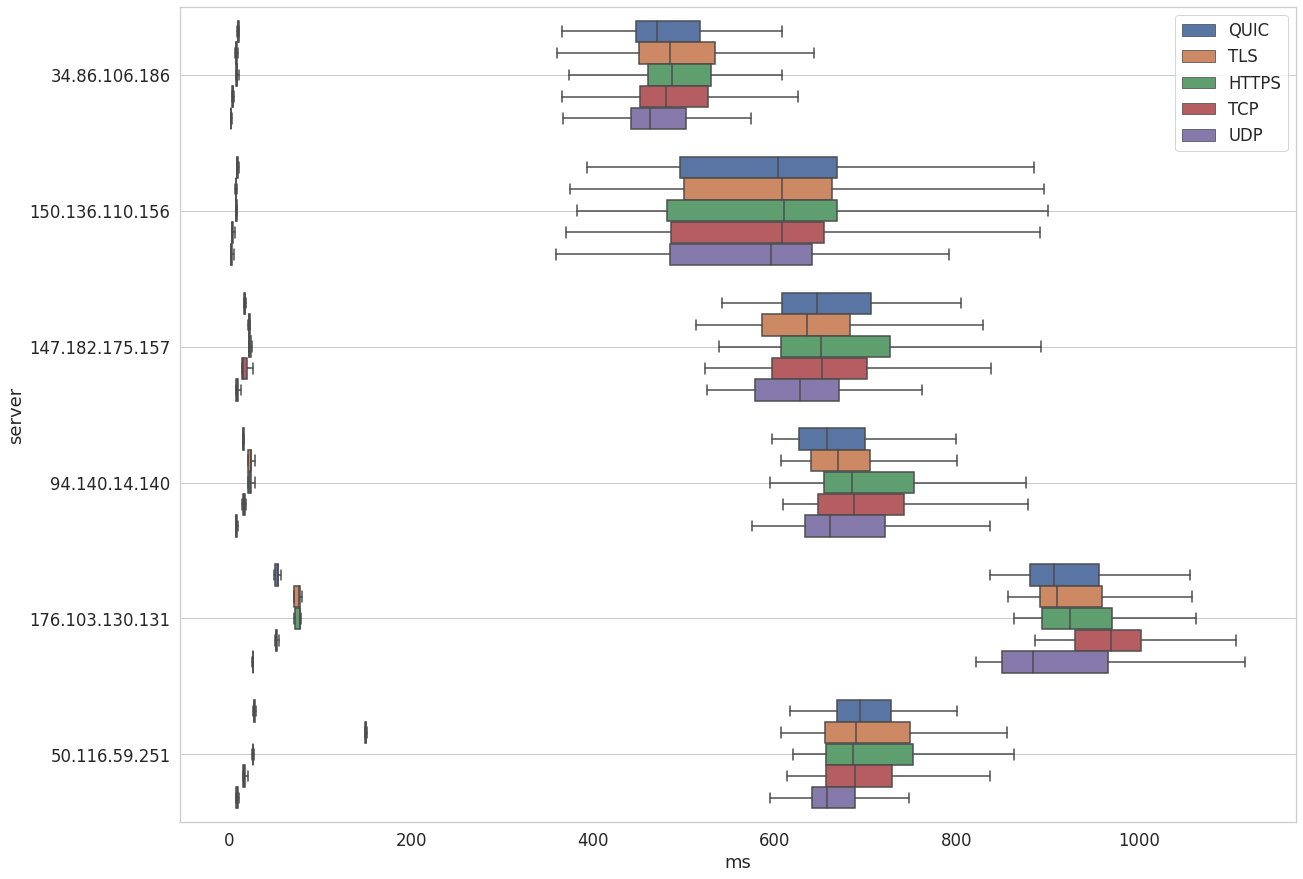

**Asia Pacific Northeast**

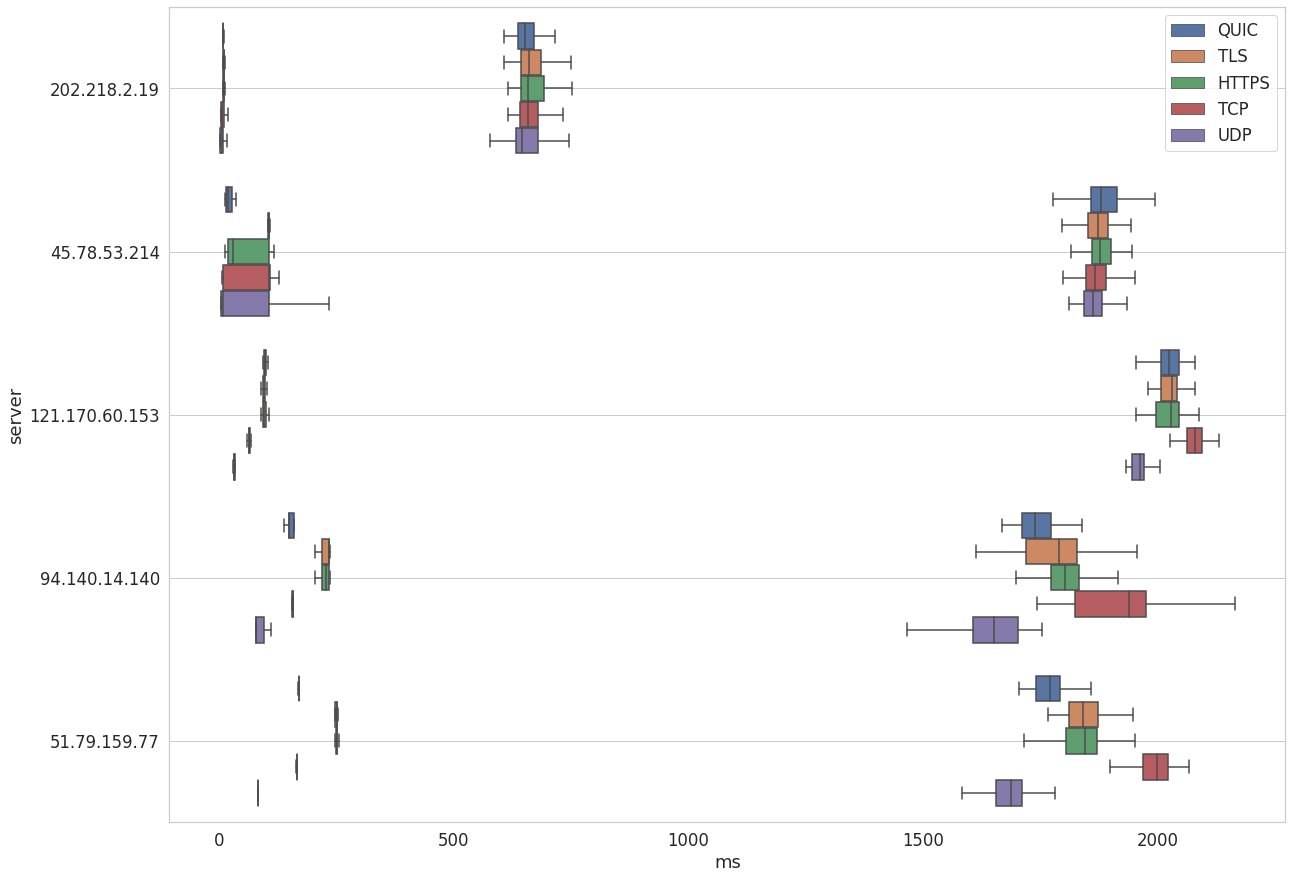

**Africa South**

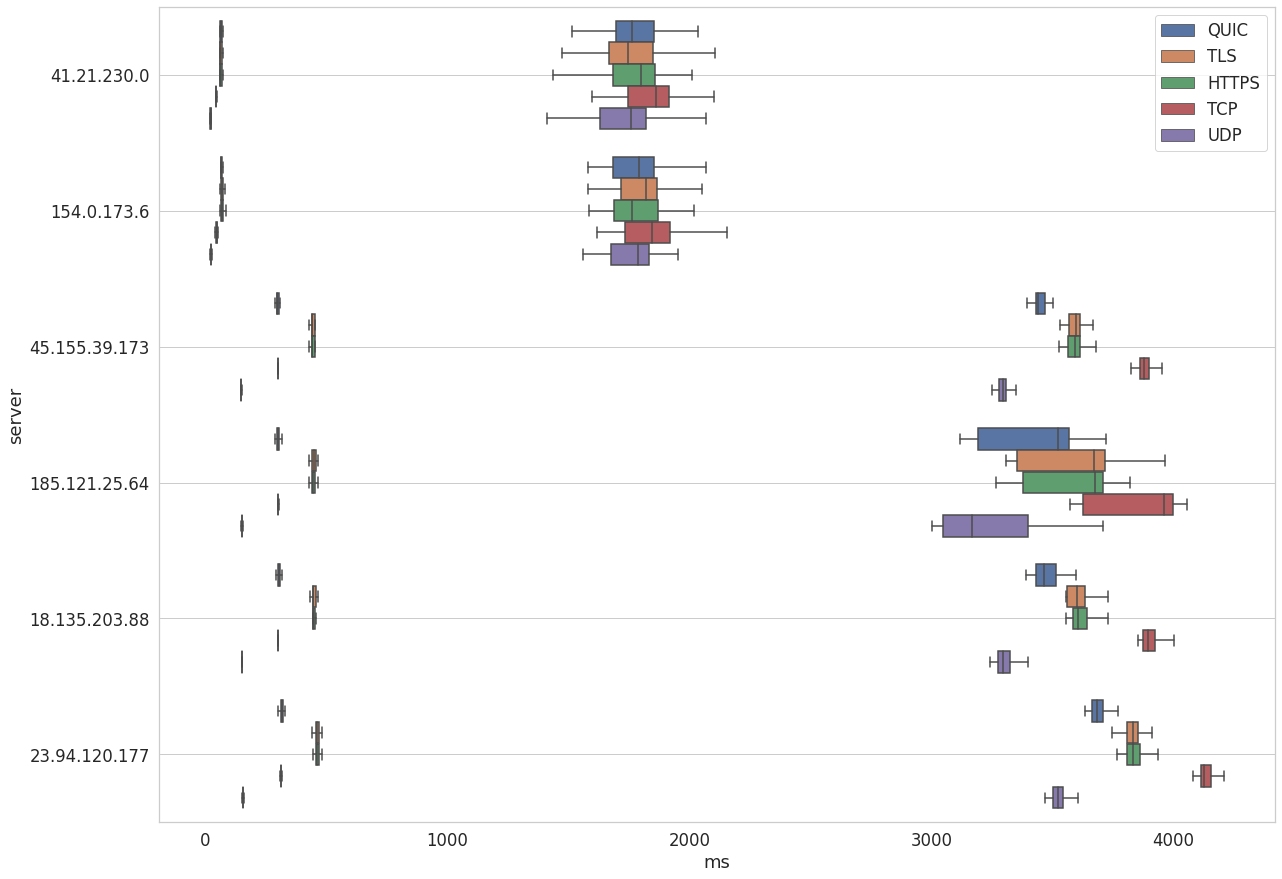

**Europe Central**

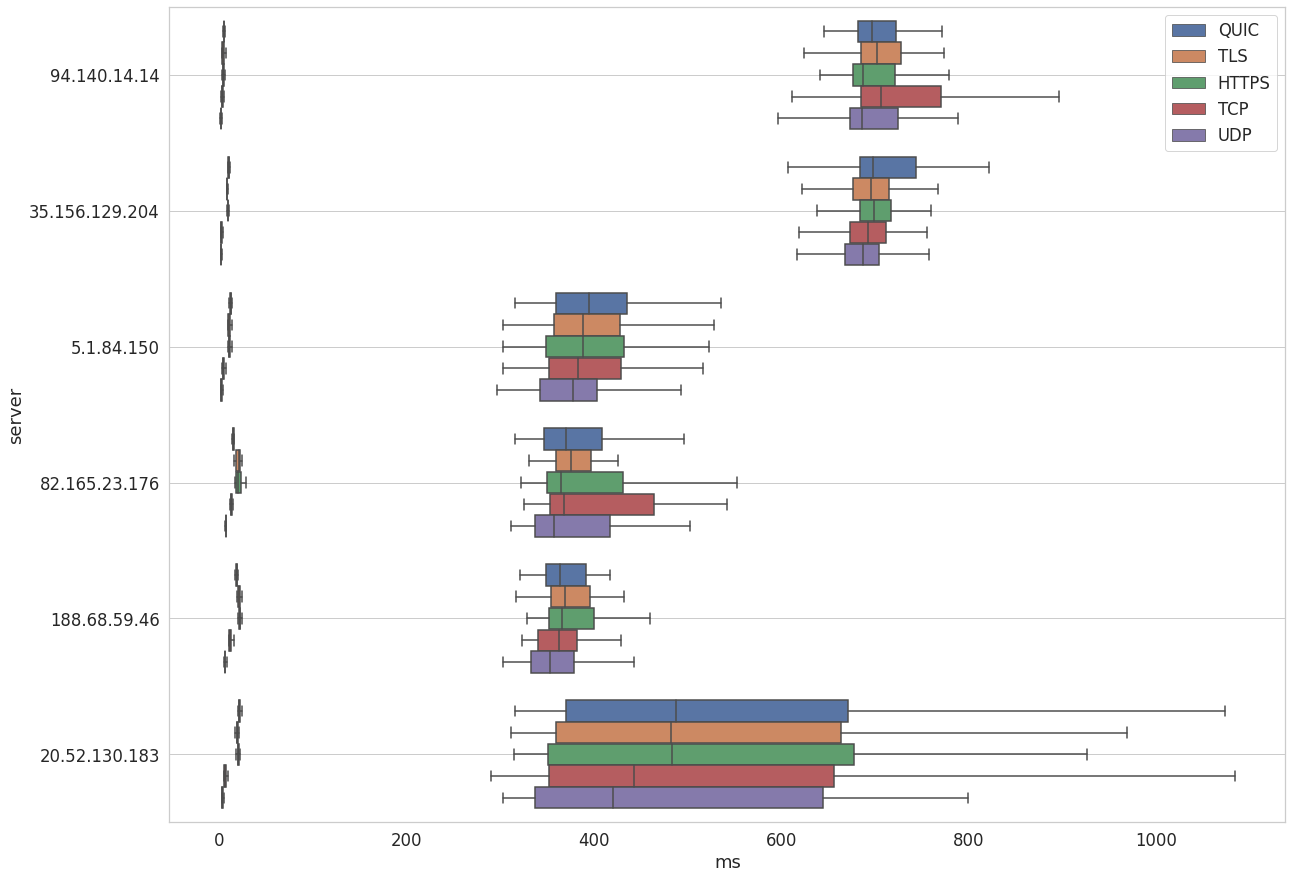

**Asia Pacific Southeast**

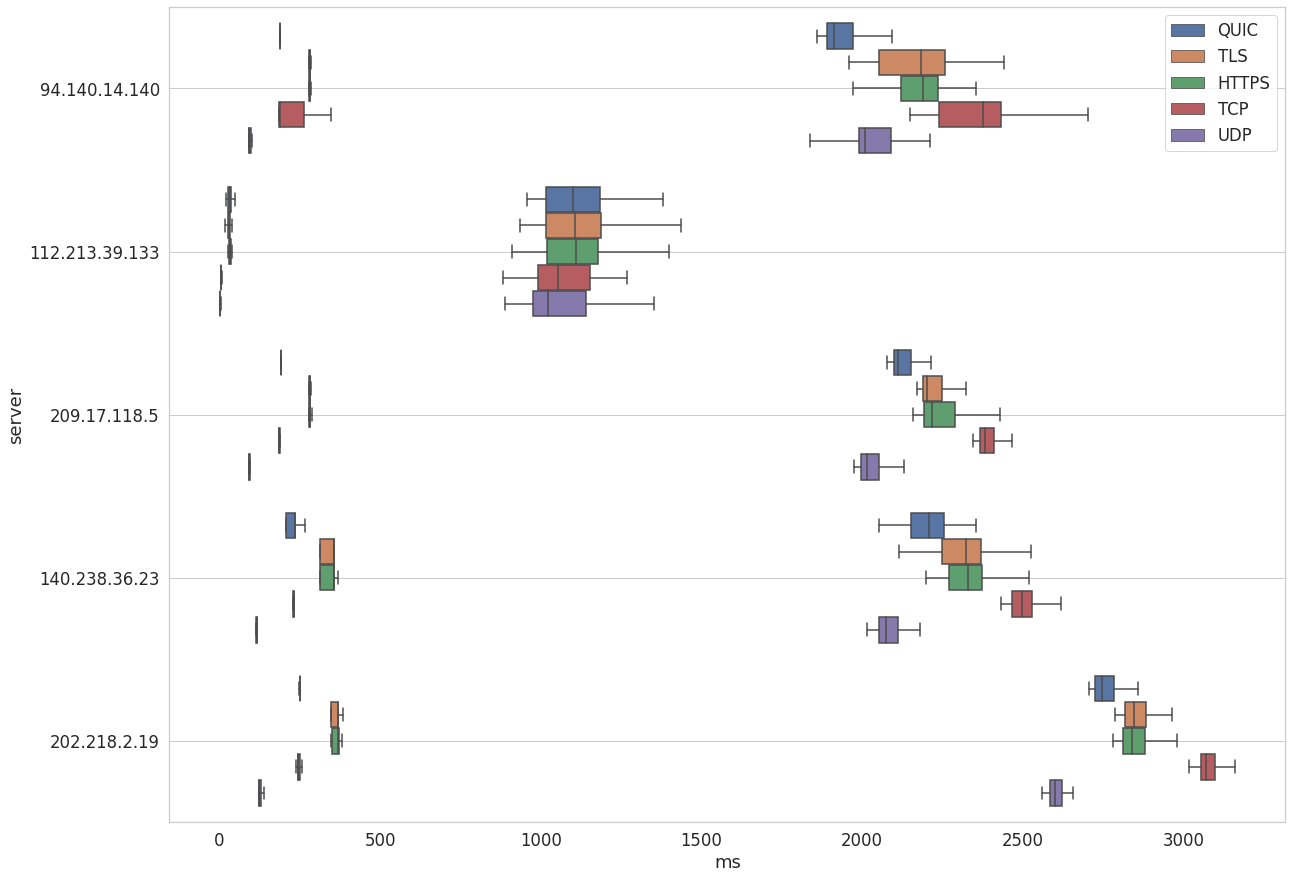

**US West**

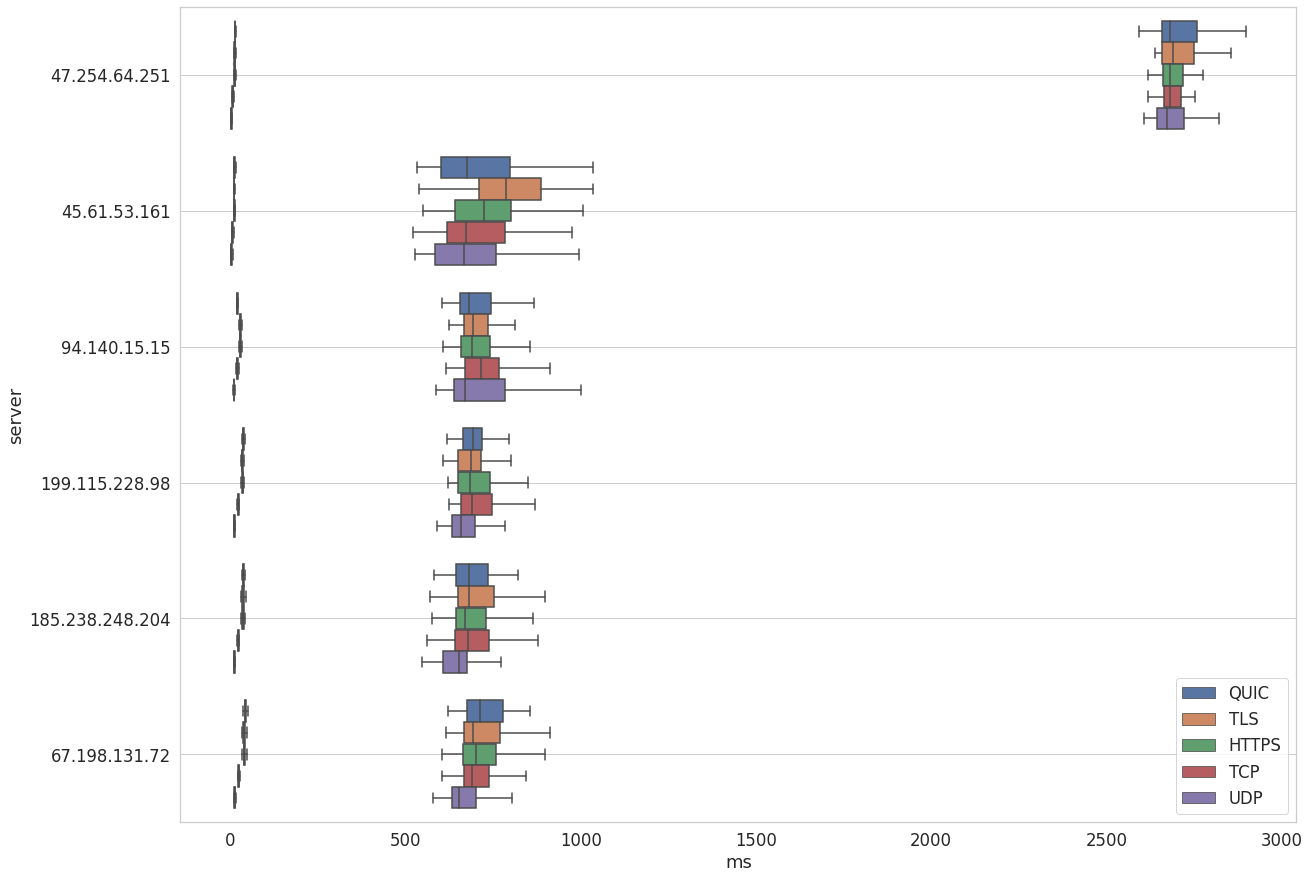

**South America East**

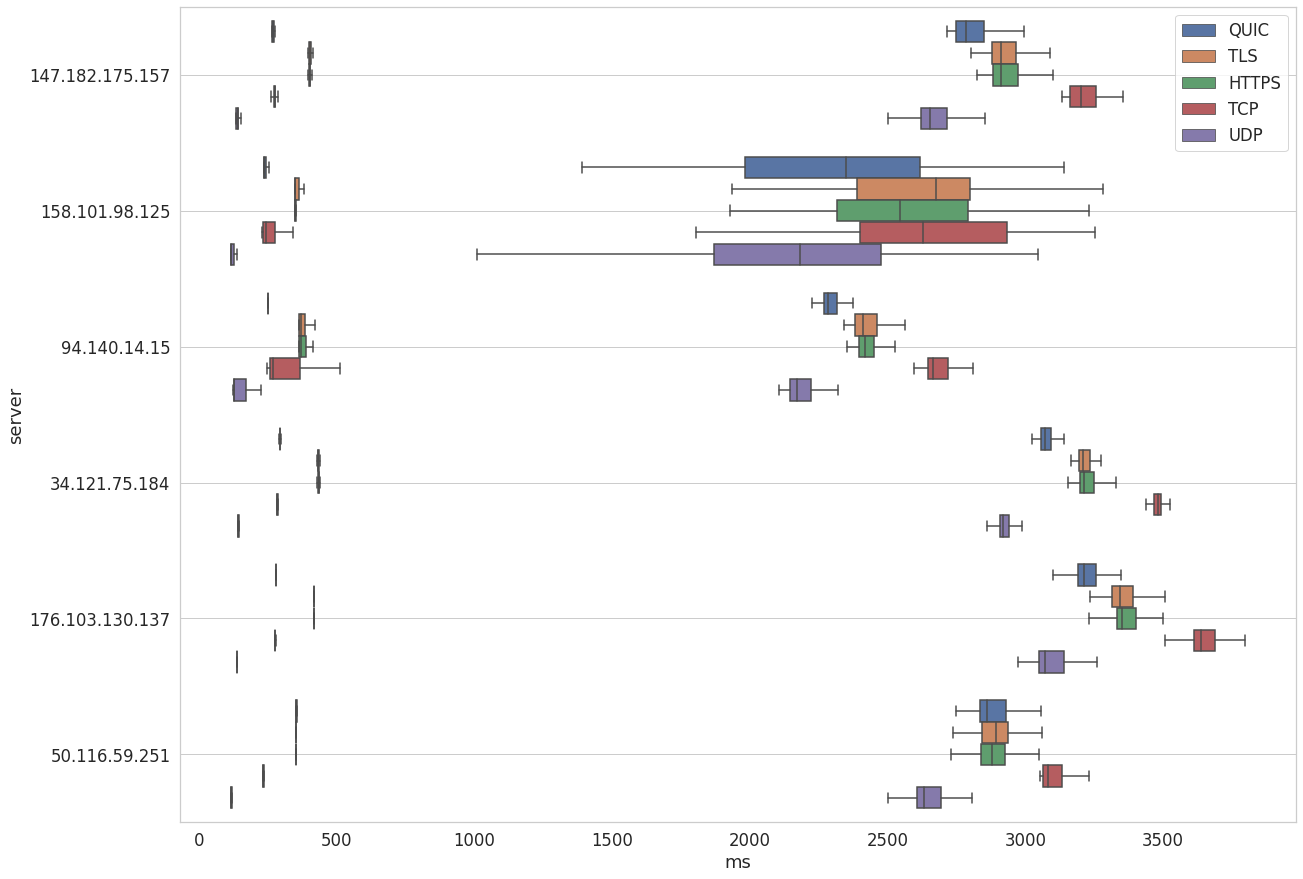

**All**

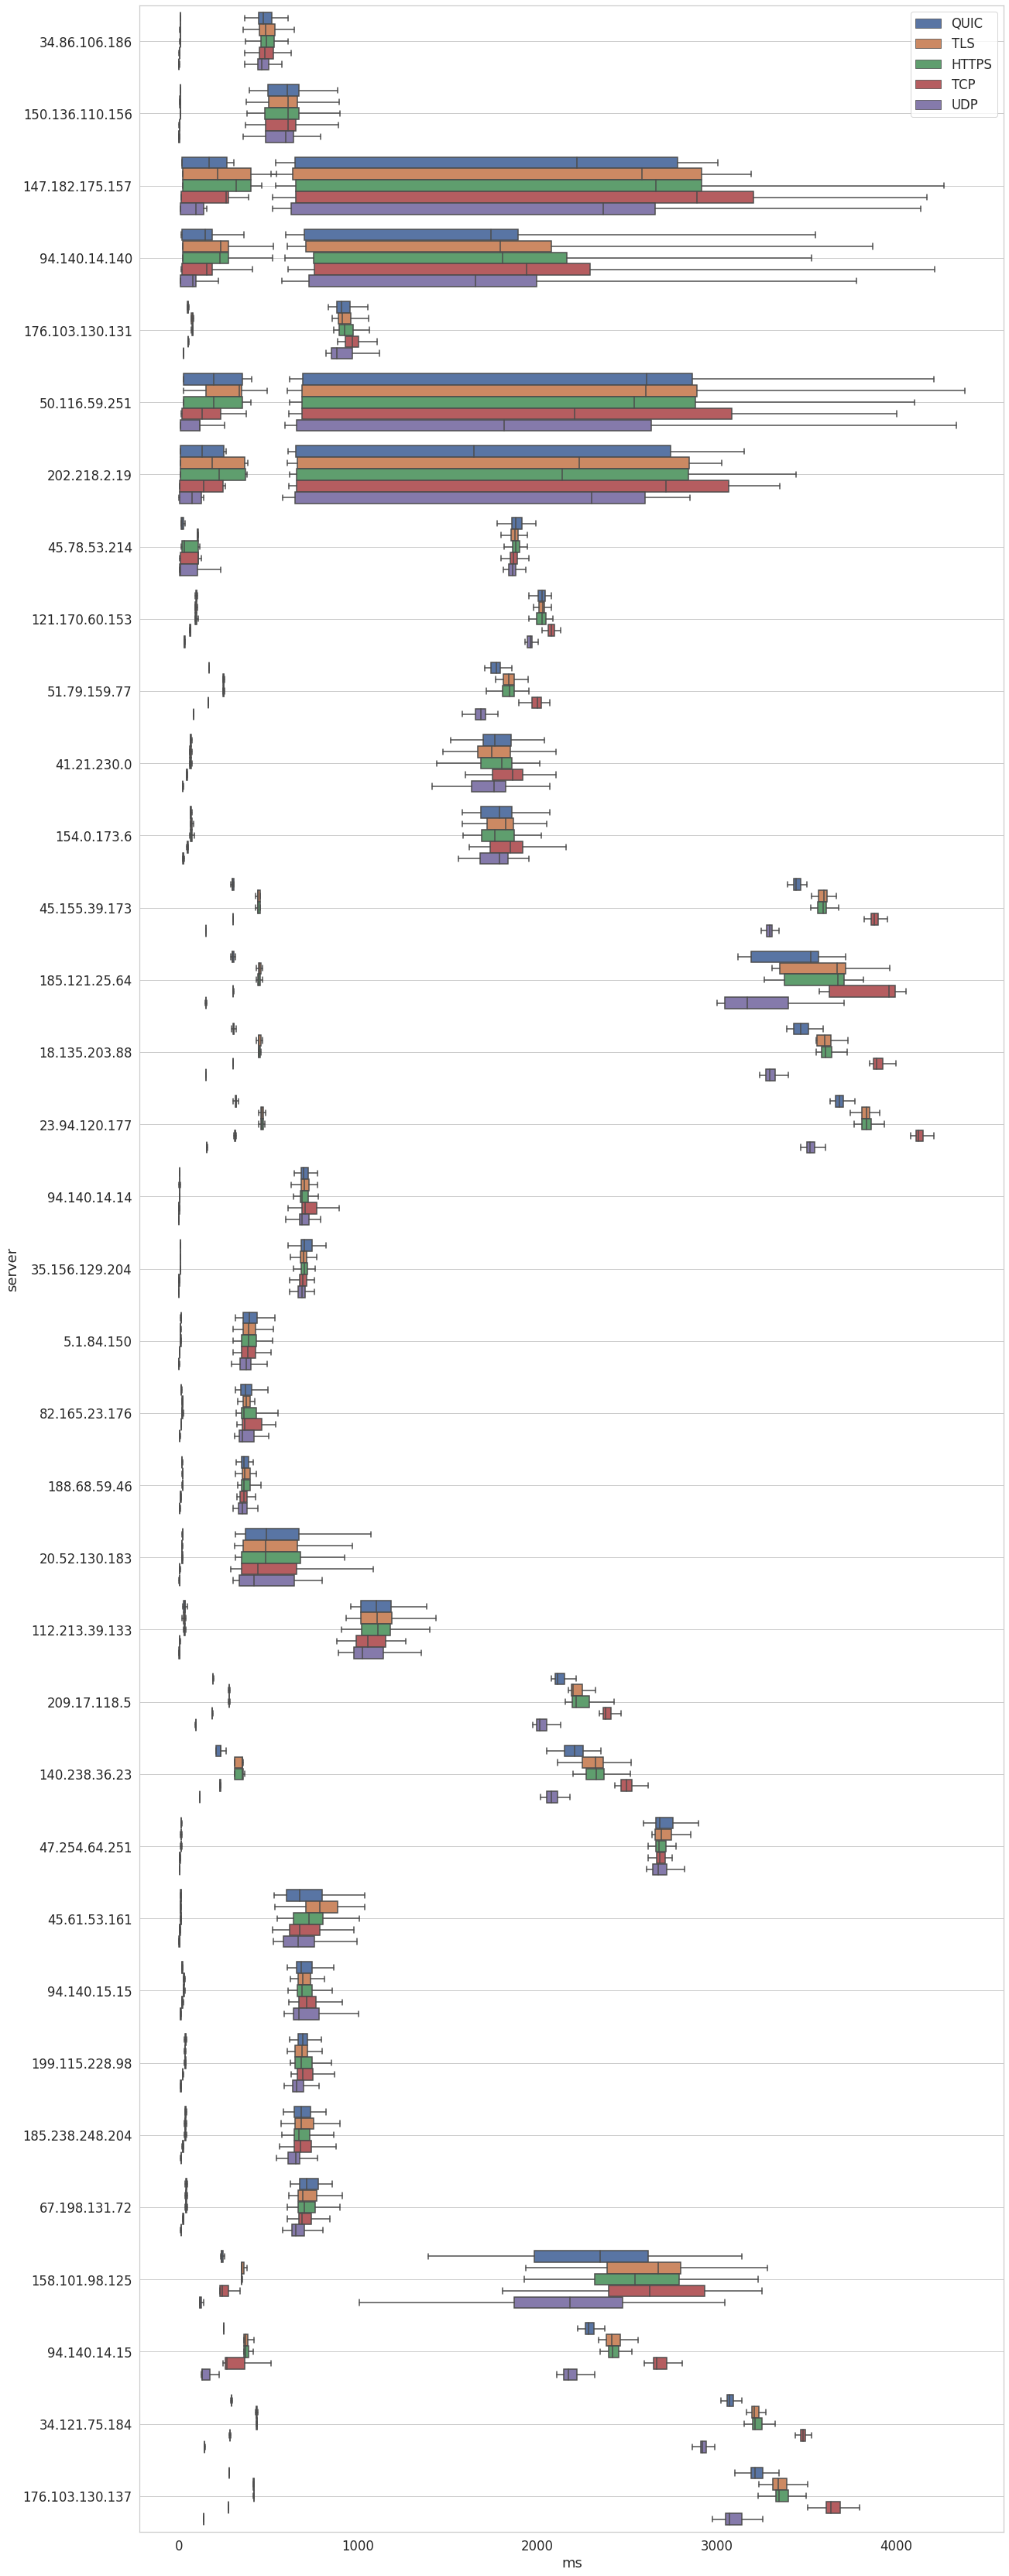

In [9]:
printmd(f"***Upstream Comparison (Lookup End -> Load Event End)***")

plt.rcParams["figure.figsize"] = (20,15)
for vantagePoint in df['vantagePoint'].unique():
    dualCompare(vantagePoint)
plt.rcParams["figure.figsize"] = (20,60)
dualCompare()

***Domain Comparison (Lookup End -> Load Event End)***

**US East**

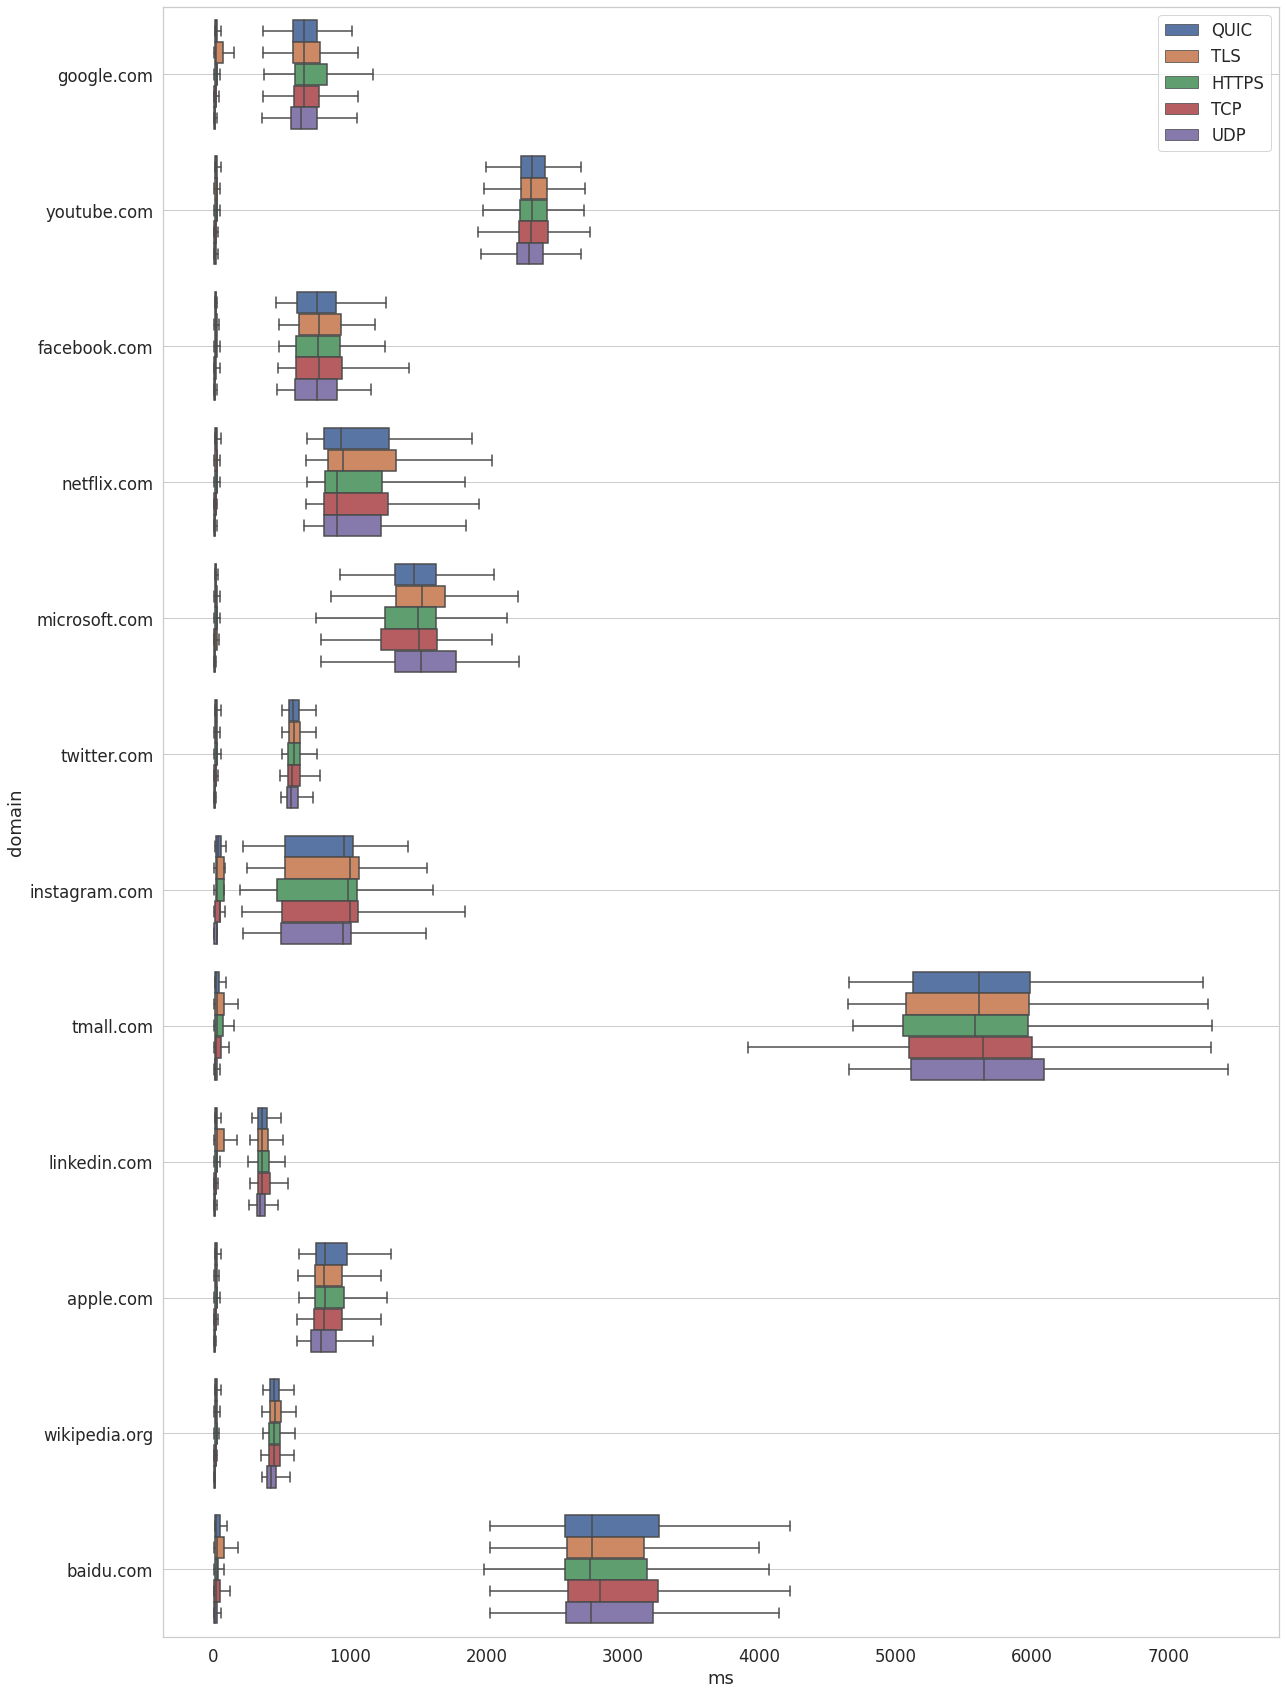

**Asia Pacific Northeast**

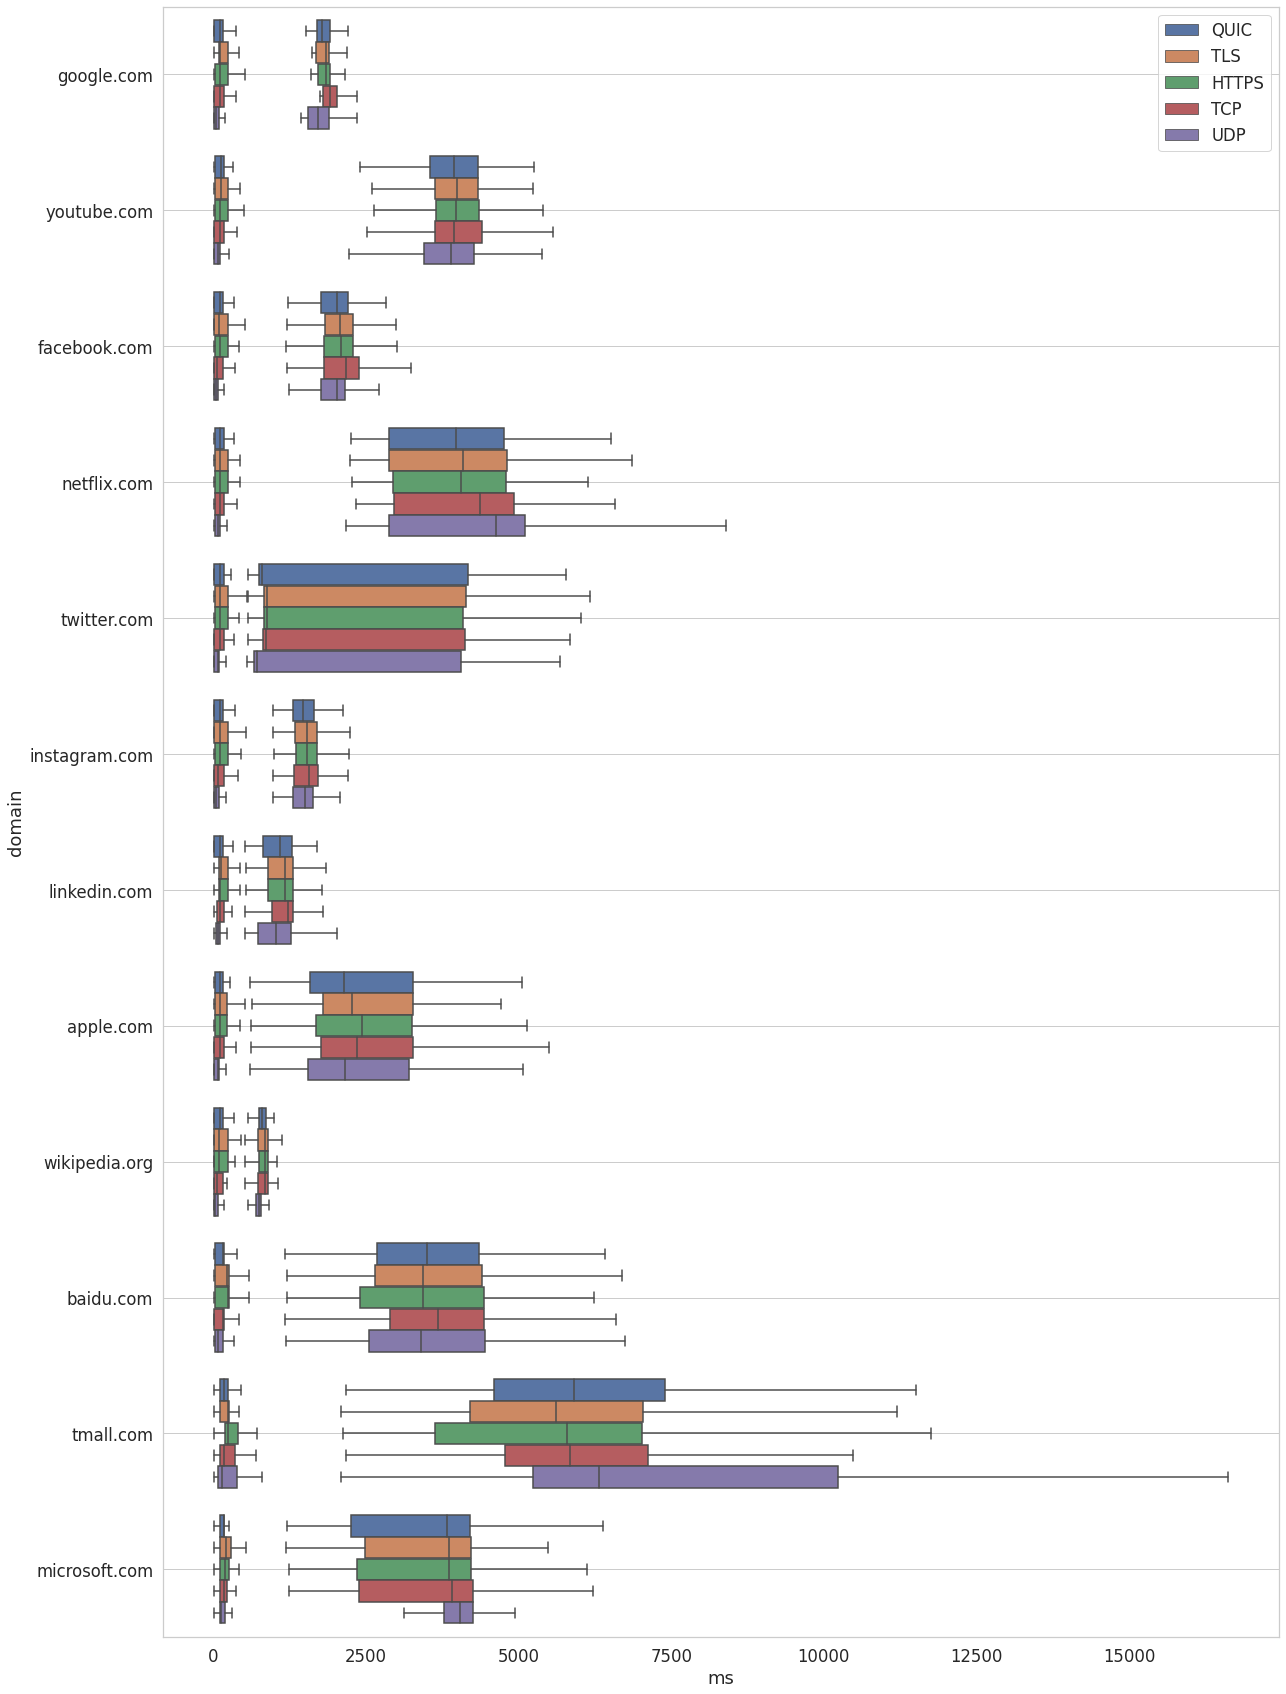

**Africa South**

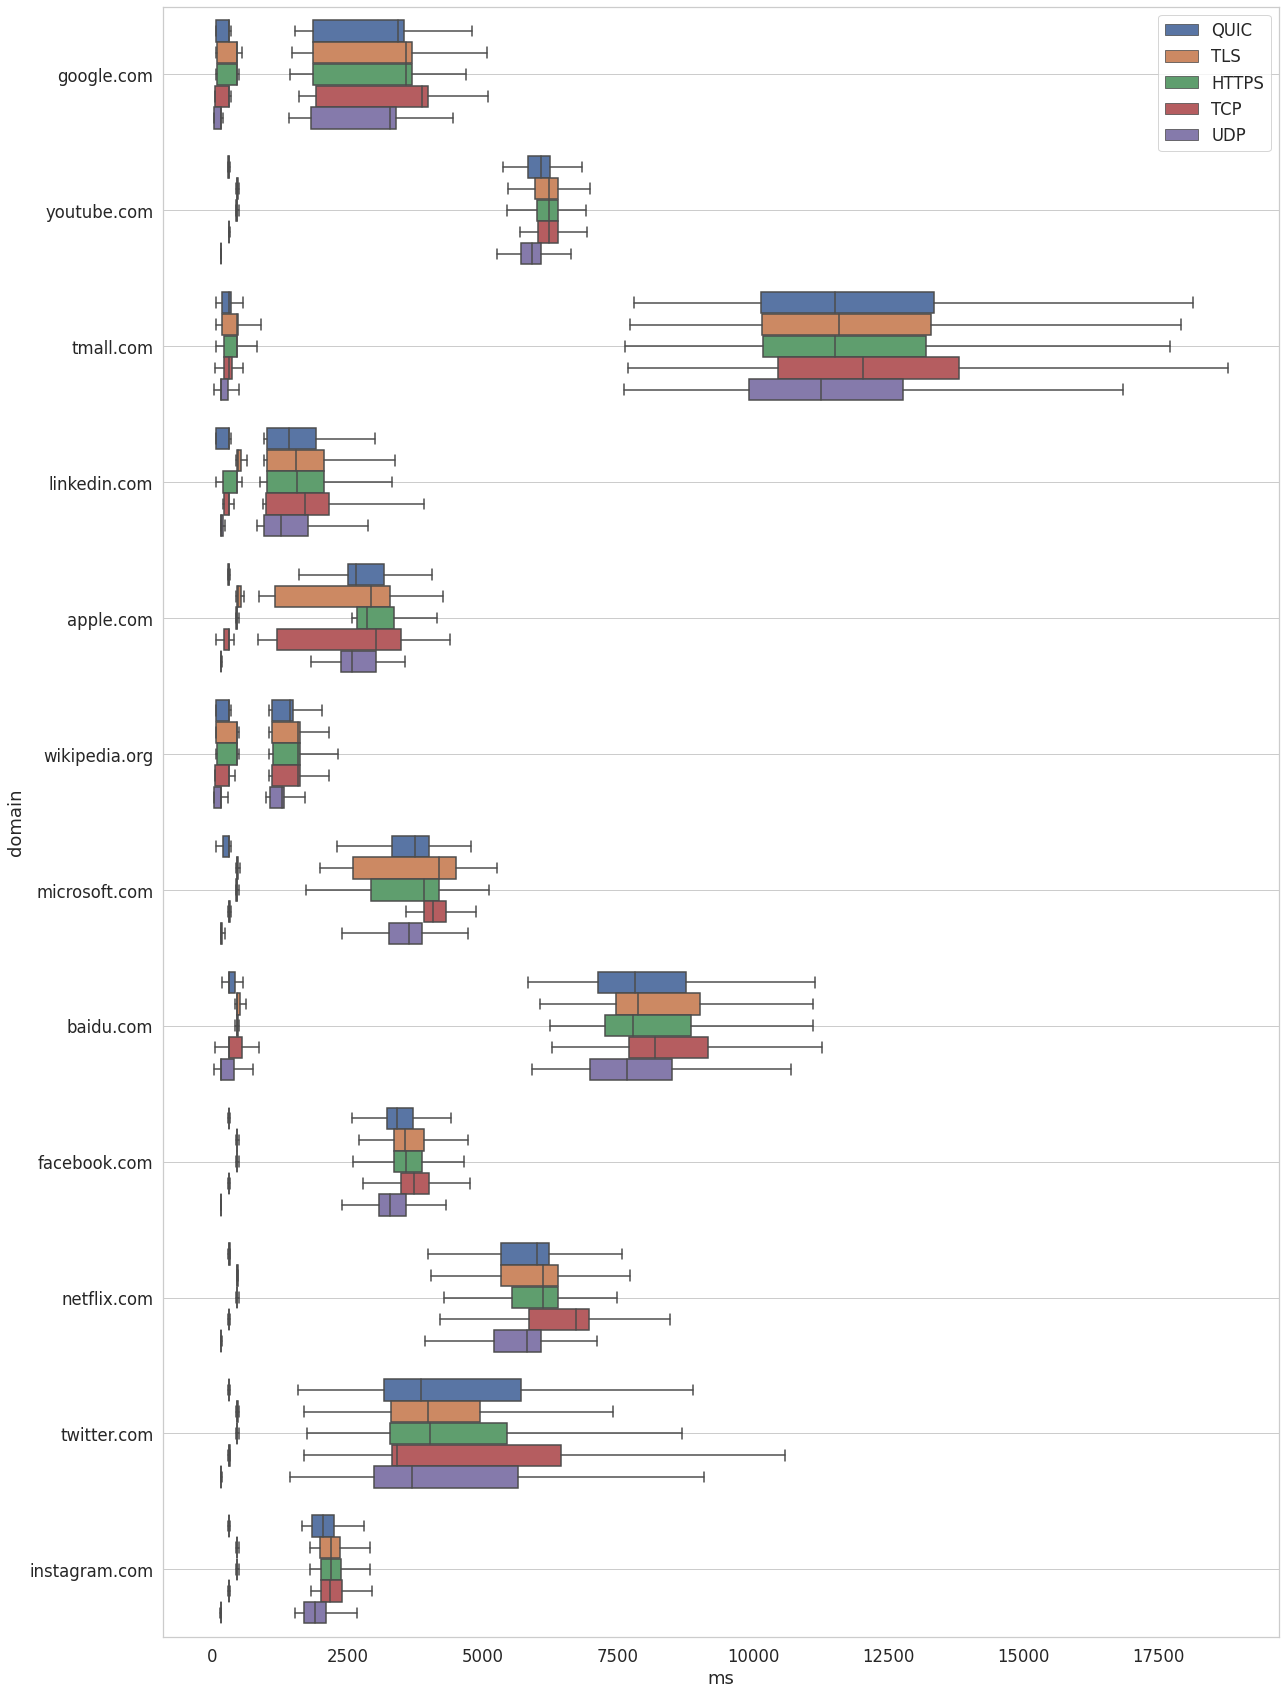

**Europe Central**

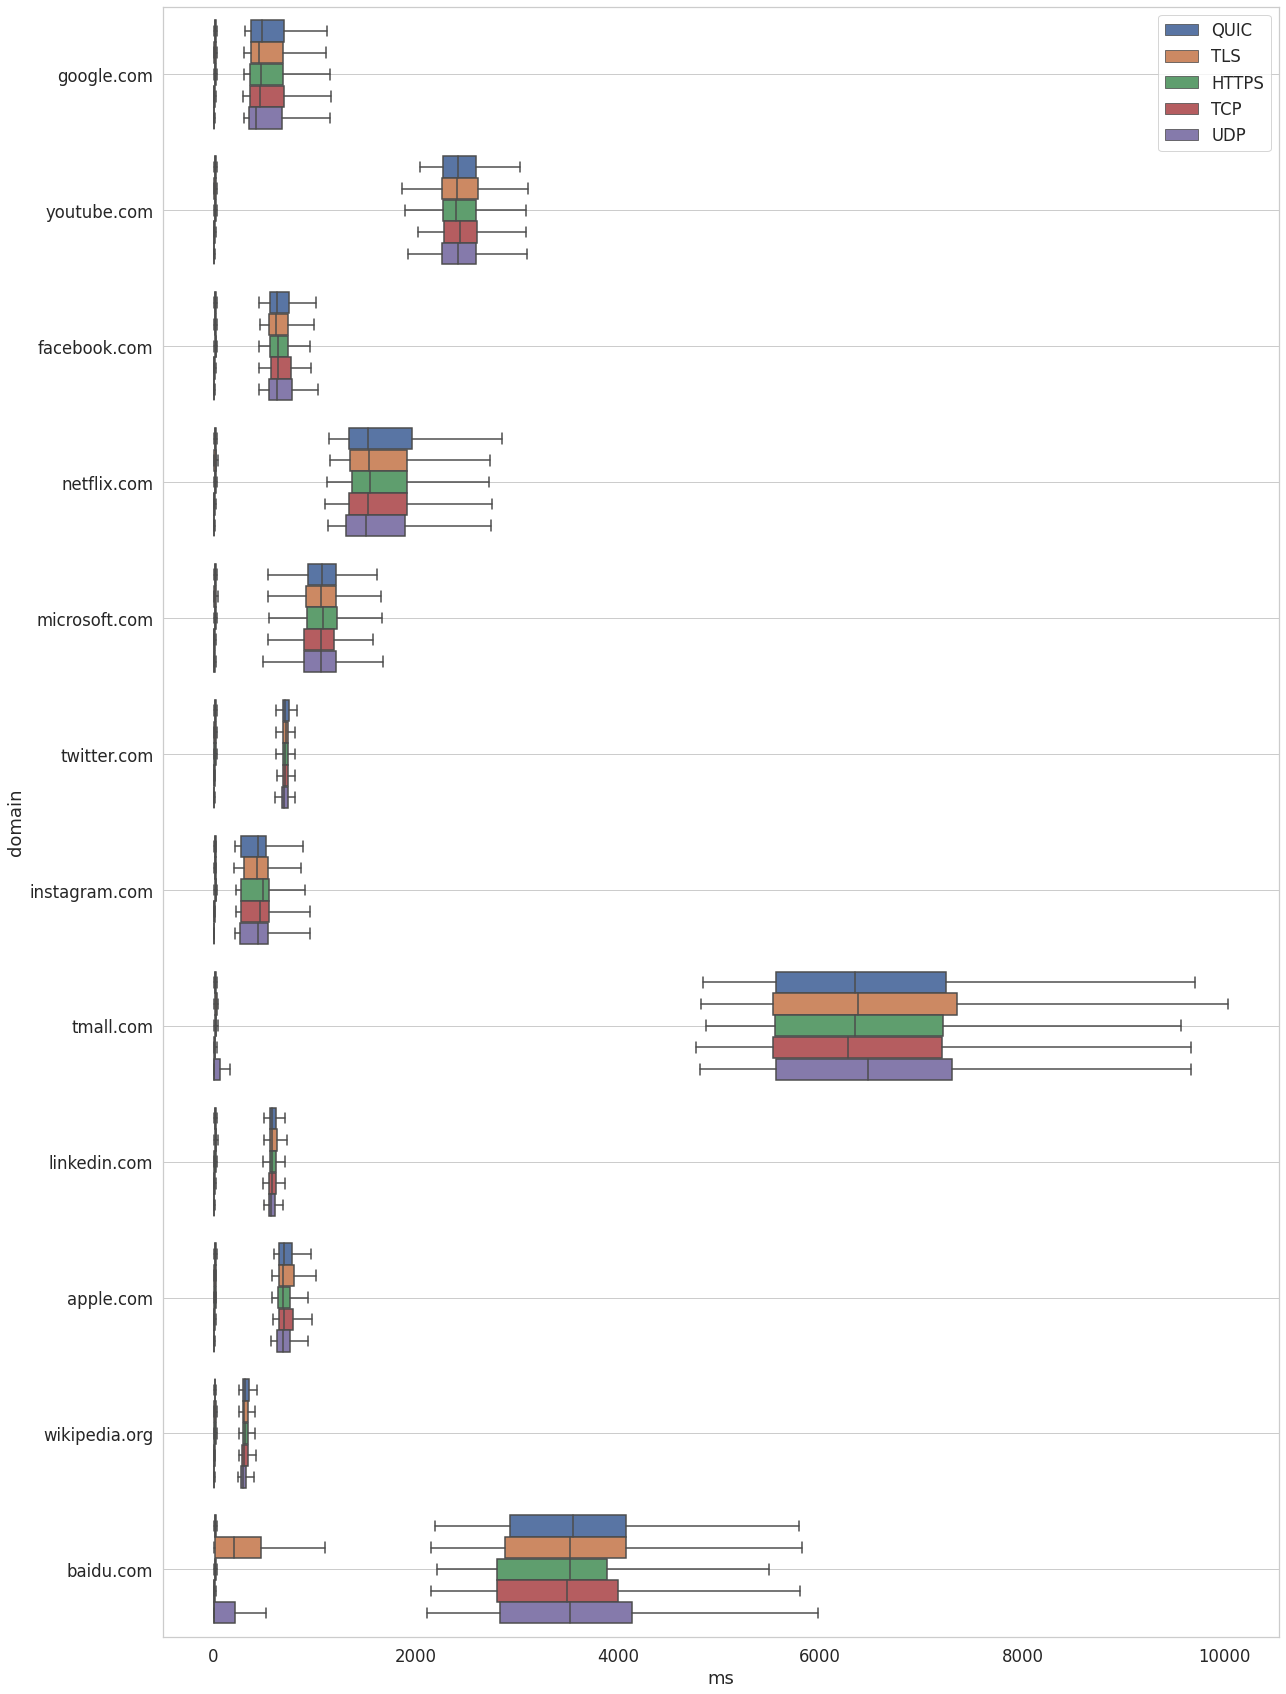

**Asia Pacific Southeast**

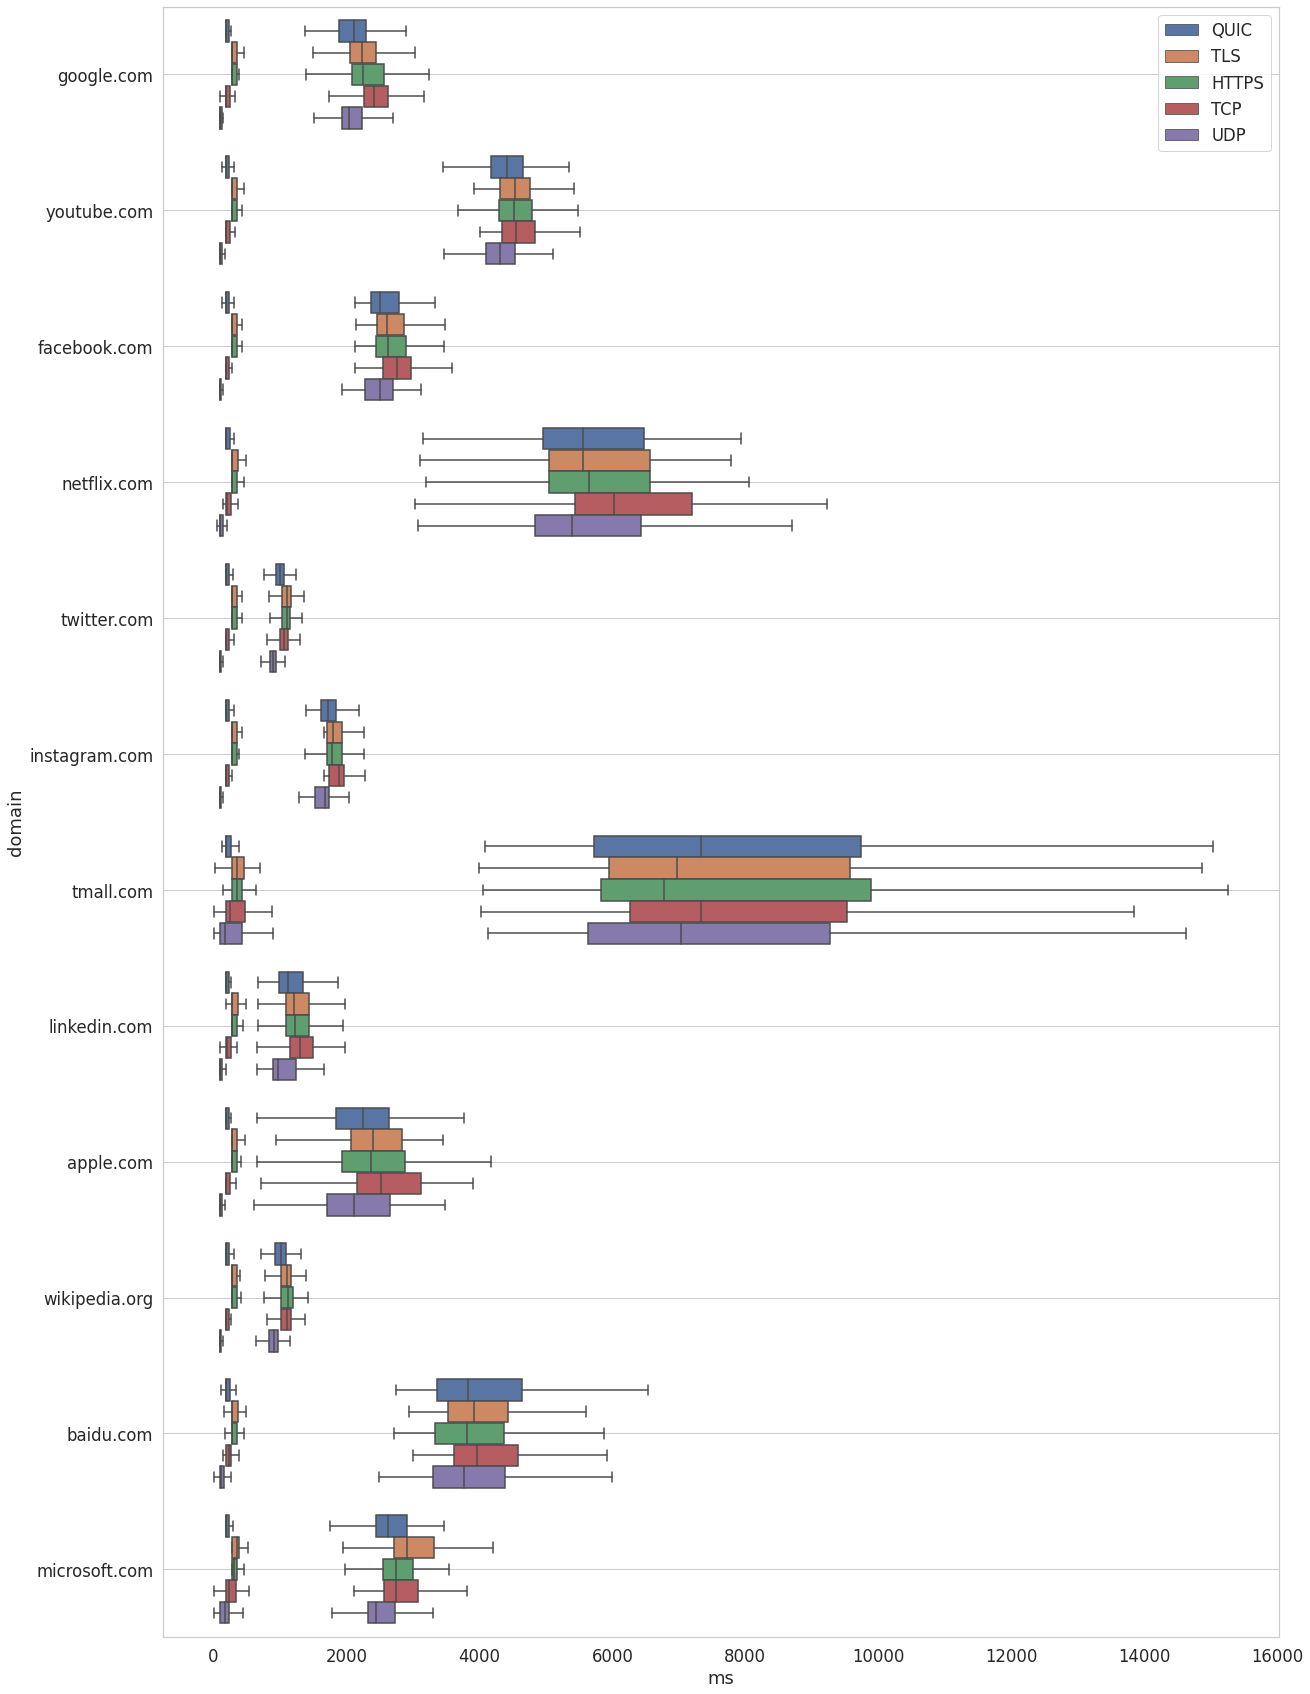

**US West**

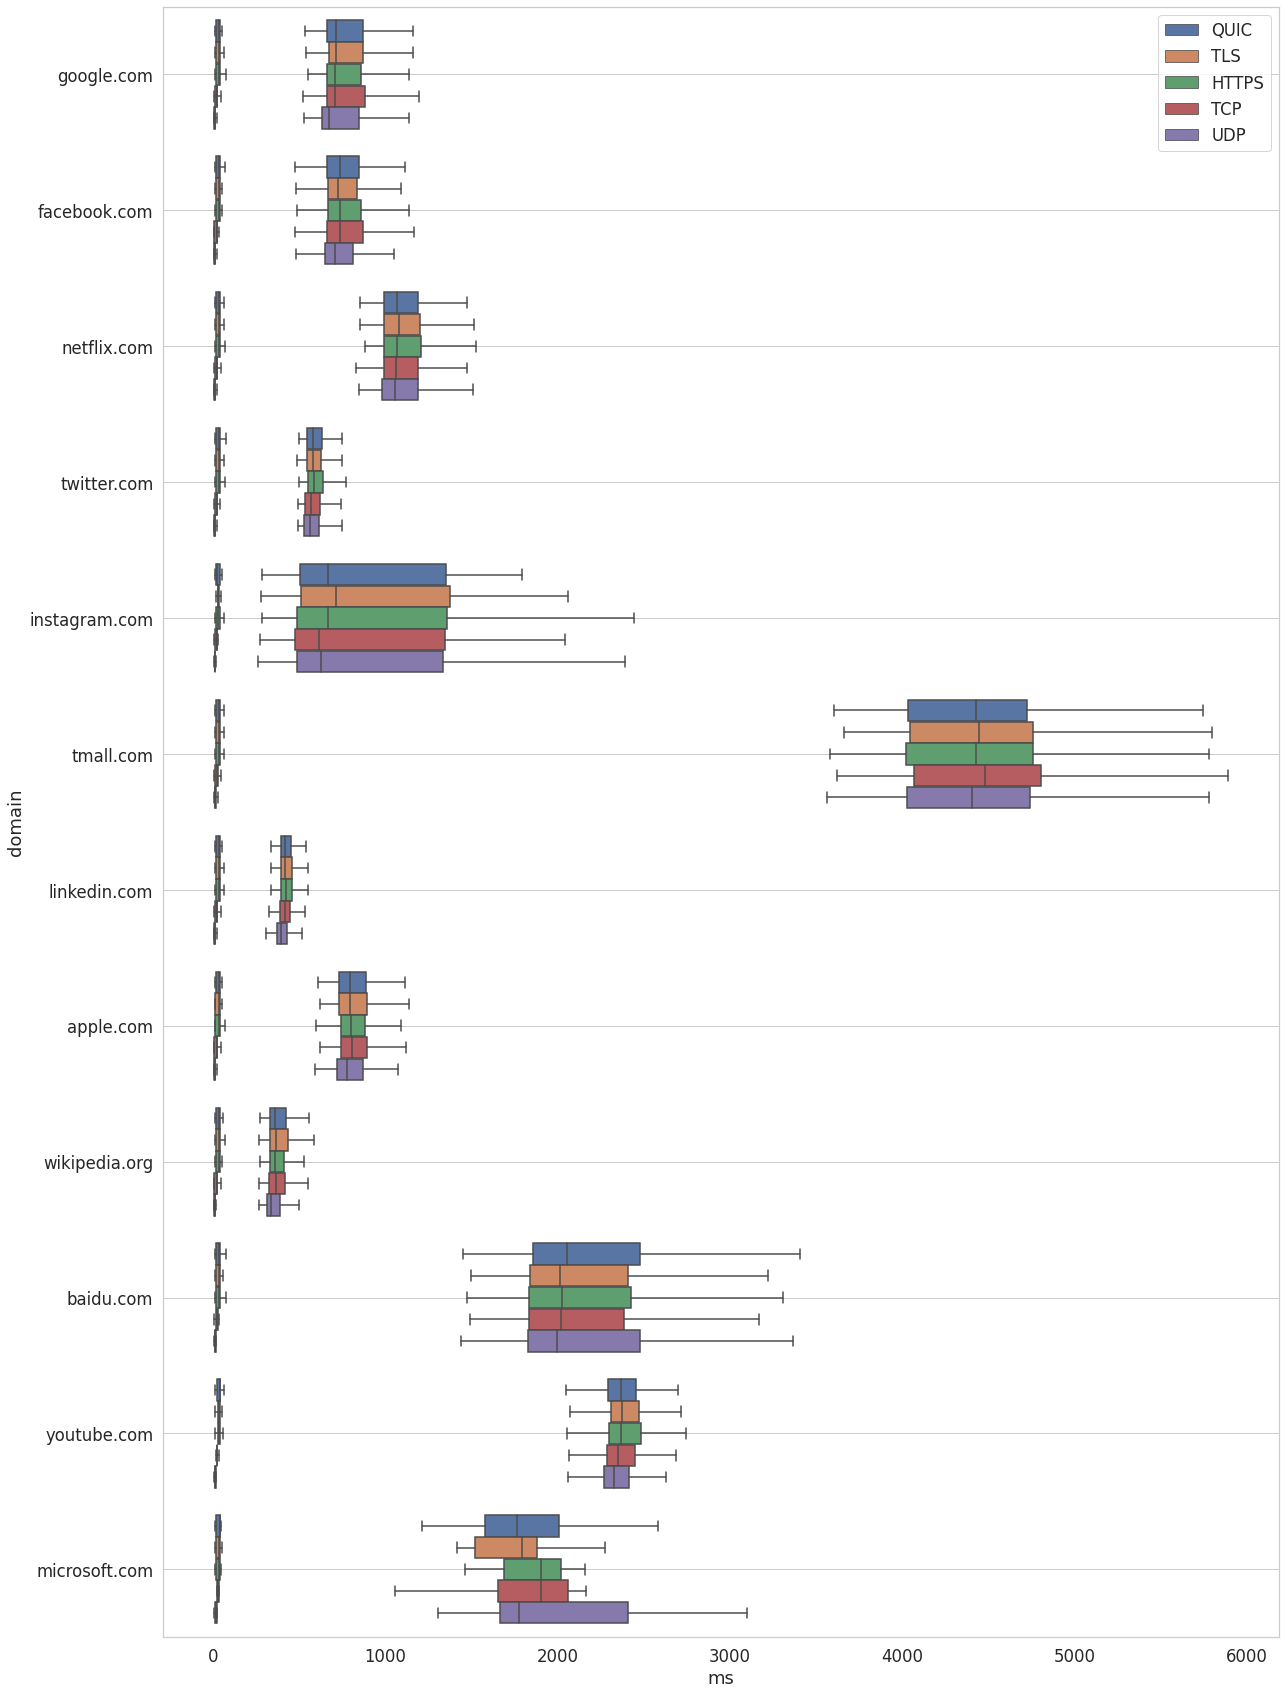

**South America East**

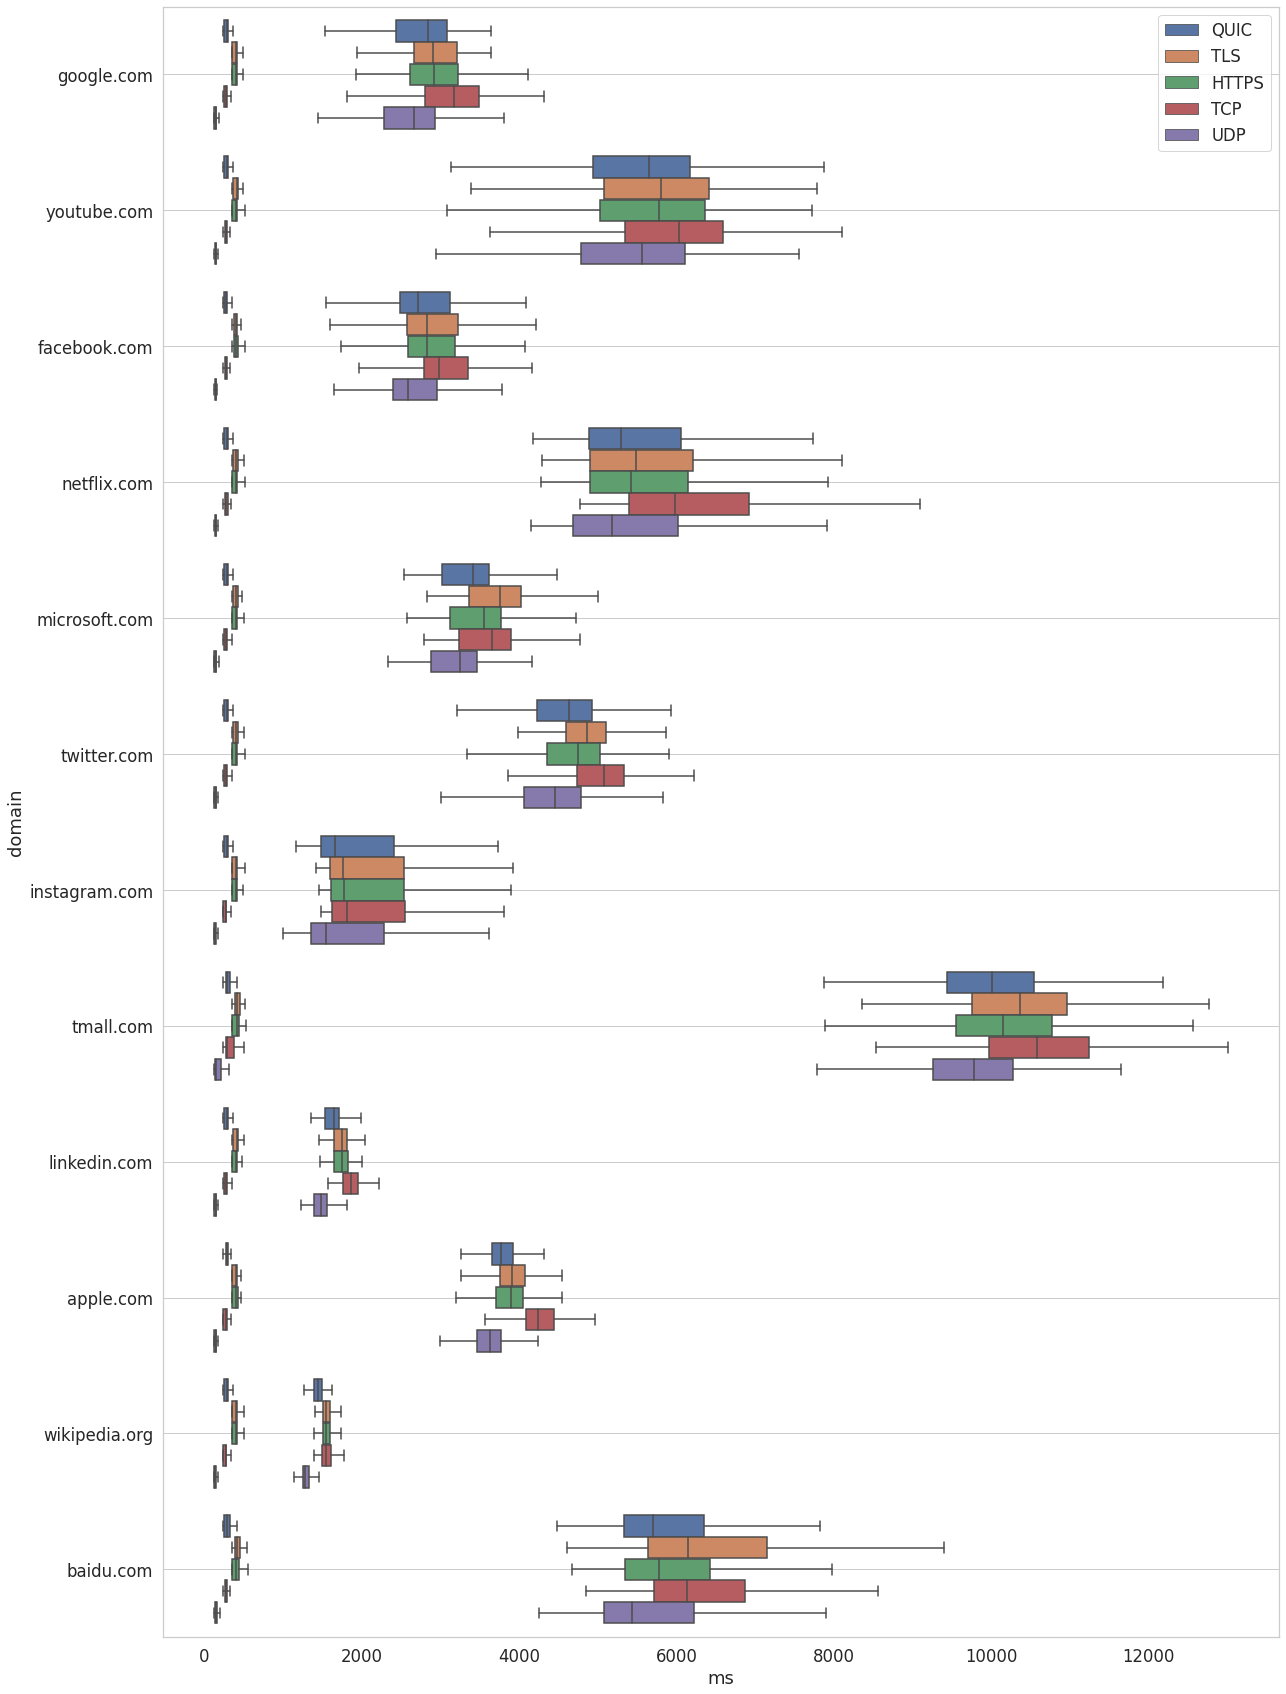

**All**

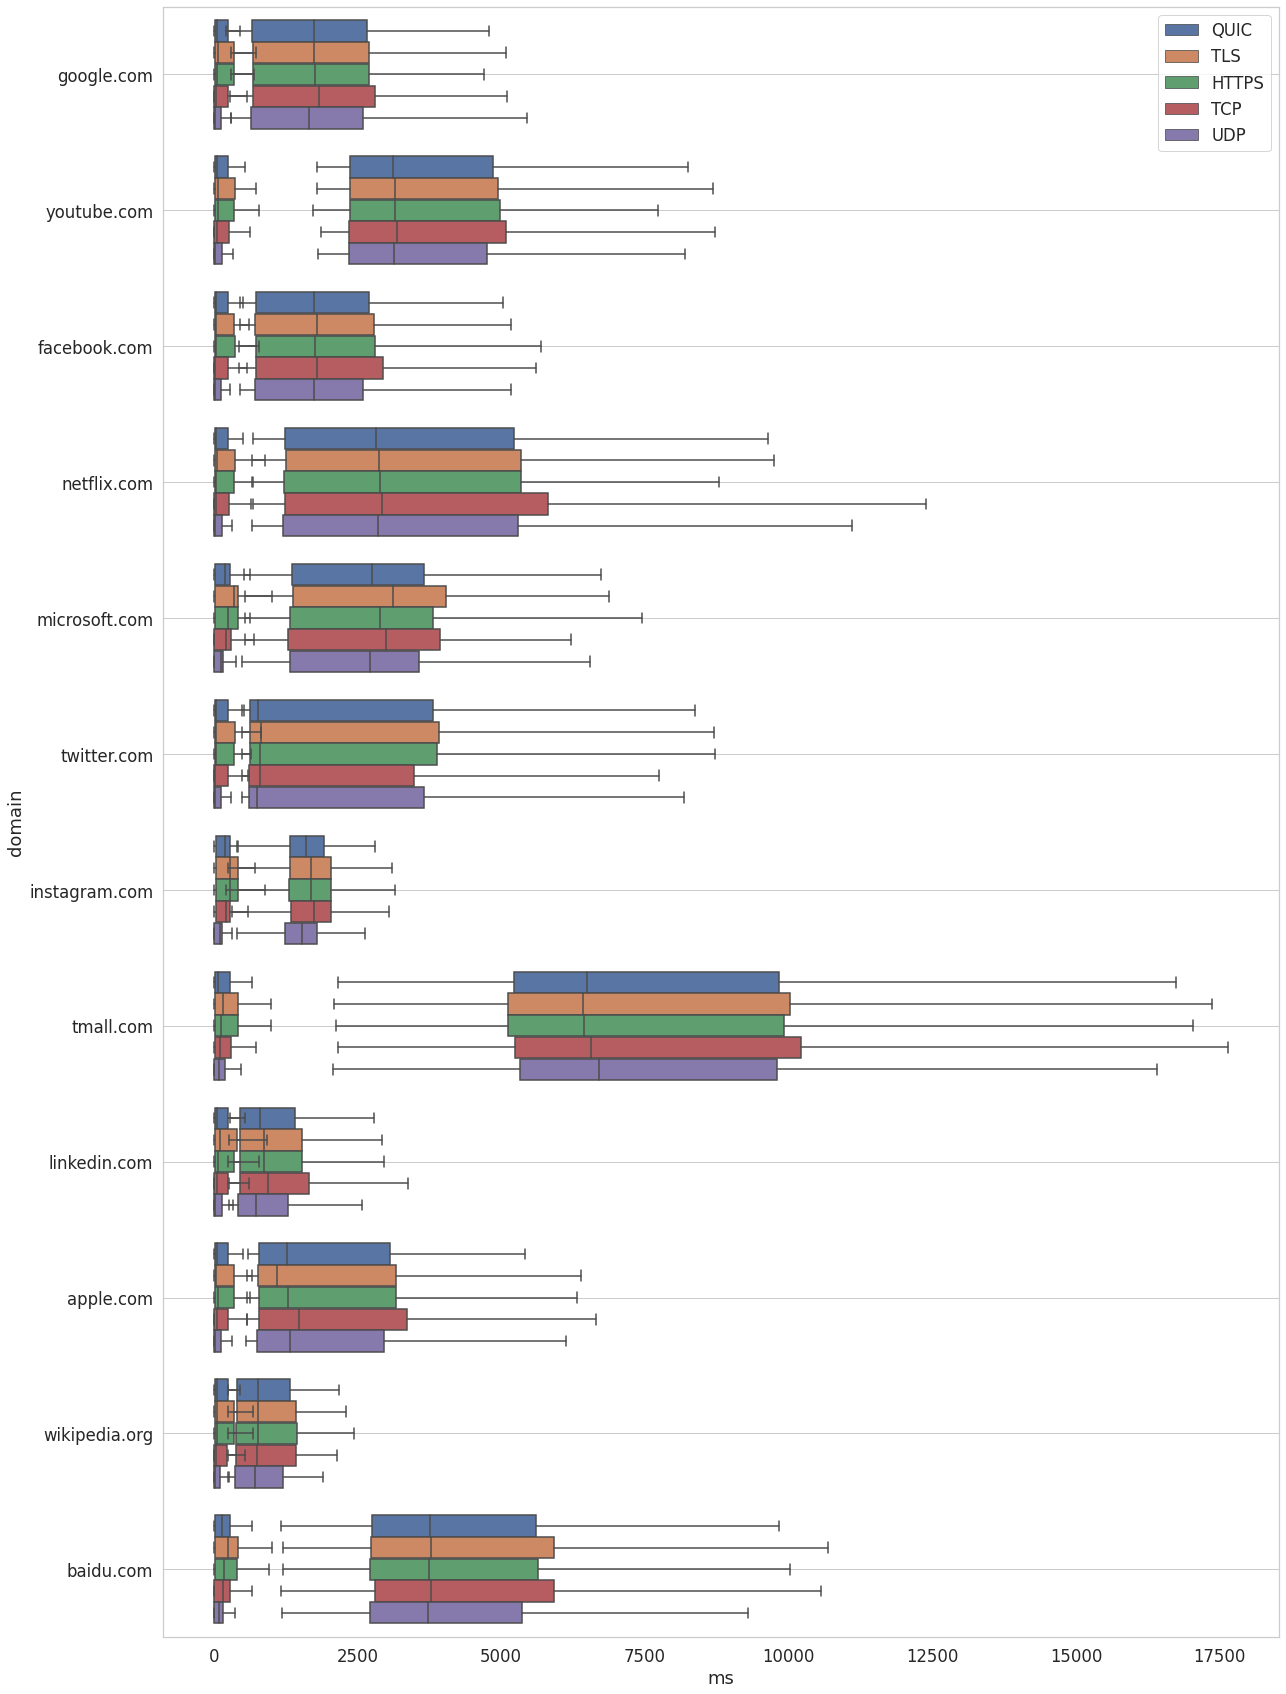

In [10]:
printmd(f"***Domain Comparison (Lookup End -> Load Event End)***")

plt.rcParams["figure.figsize"] = (20,30)
for vantagePoint in df['vantagePoint'].unique():
    dualCompare(vantagePoint, 'domain', '')
dualCompare('All', 'domain', '')

In [11]:
def singleCompareServers(vantagePoint='All', value_var='max_lookup_end', showfliers=True):
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    if vantagePoint == 'All':
        df_vp = df
    else:
        df_vp = df[df['vantagePoint'] == vantagePoint]
    printmd(f"**{vantagePoint}**")
    
    df_melted = pd.melt(df_vp, id_vars=['protocol', 'server'], value_vars=value_var)
    ax = sns.boxplot(x='value', y='server', hue='protocol', hue_order=protocols, data=df_melted[df_melted['variable'] == value_var], orient='h', showfliers=showfliers)
    ax.set_ylabel('server')
    ax.set_xlabel('ms')
    ax.grid()
    plt.show()

***Server Comparison (Lookup End)***

**US East**

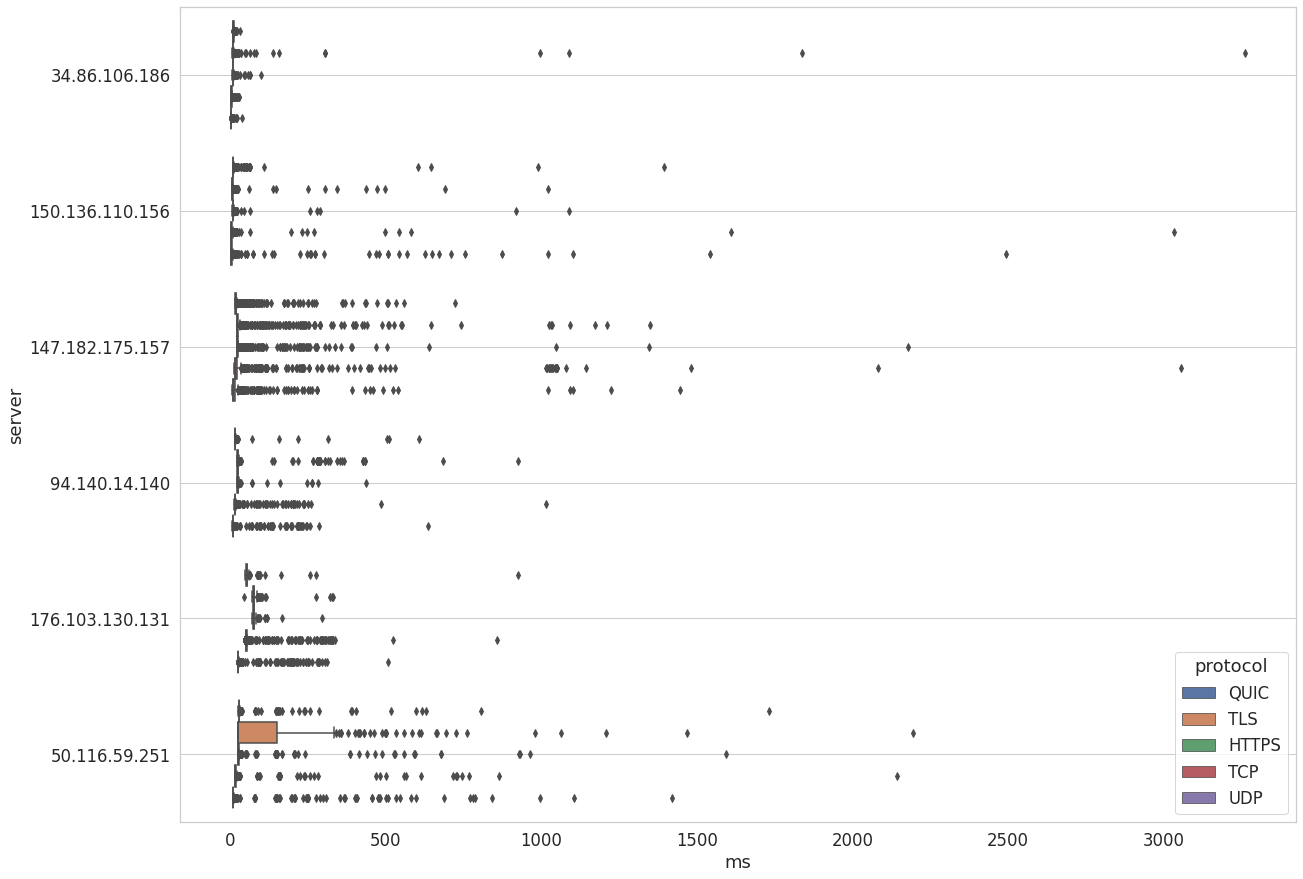

**Asia Pacific Northeast**

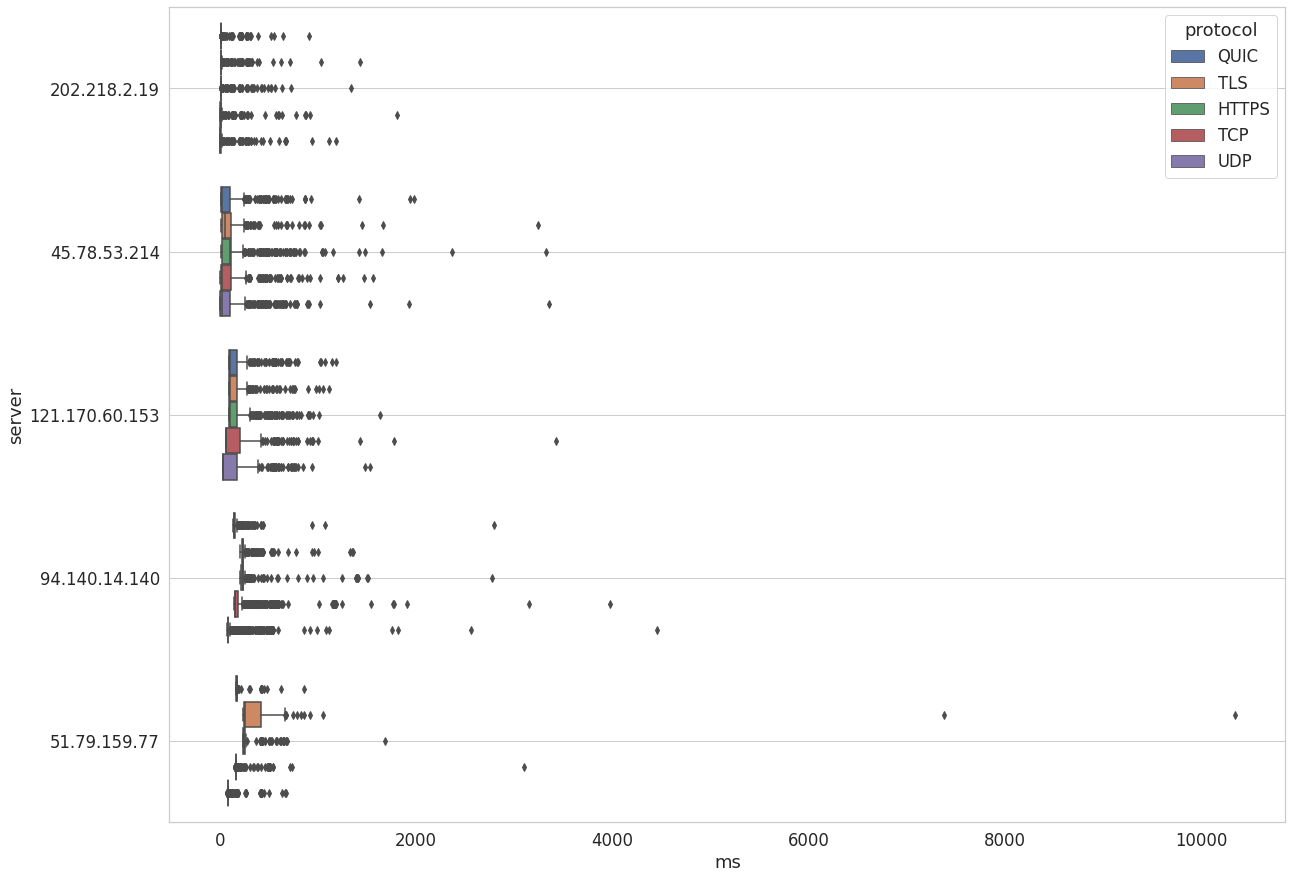

**Africa South**

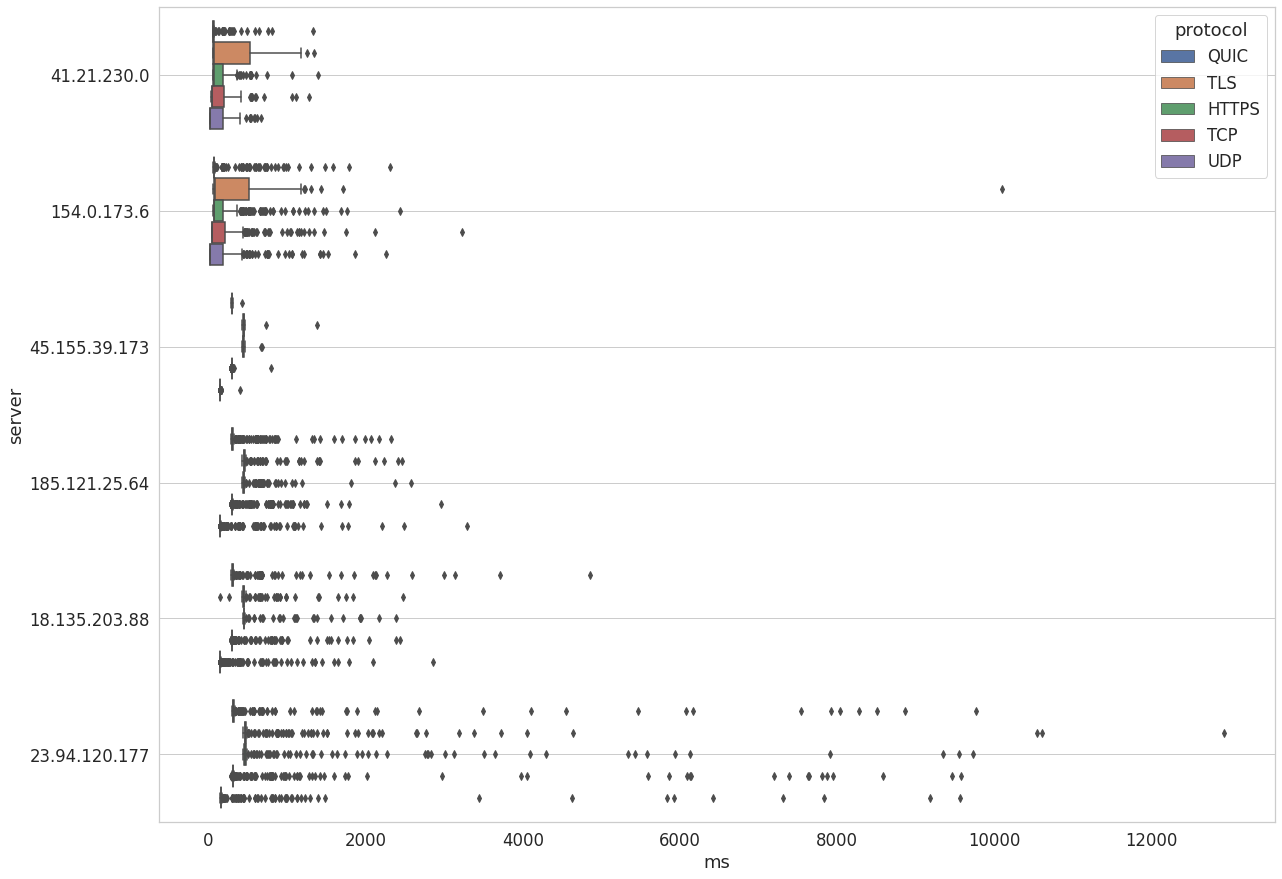

**Europe Central**

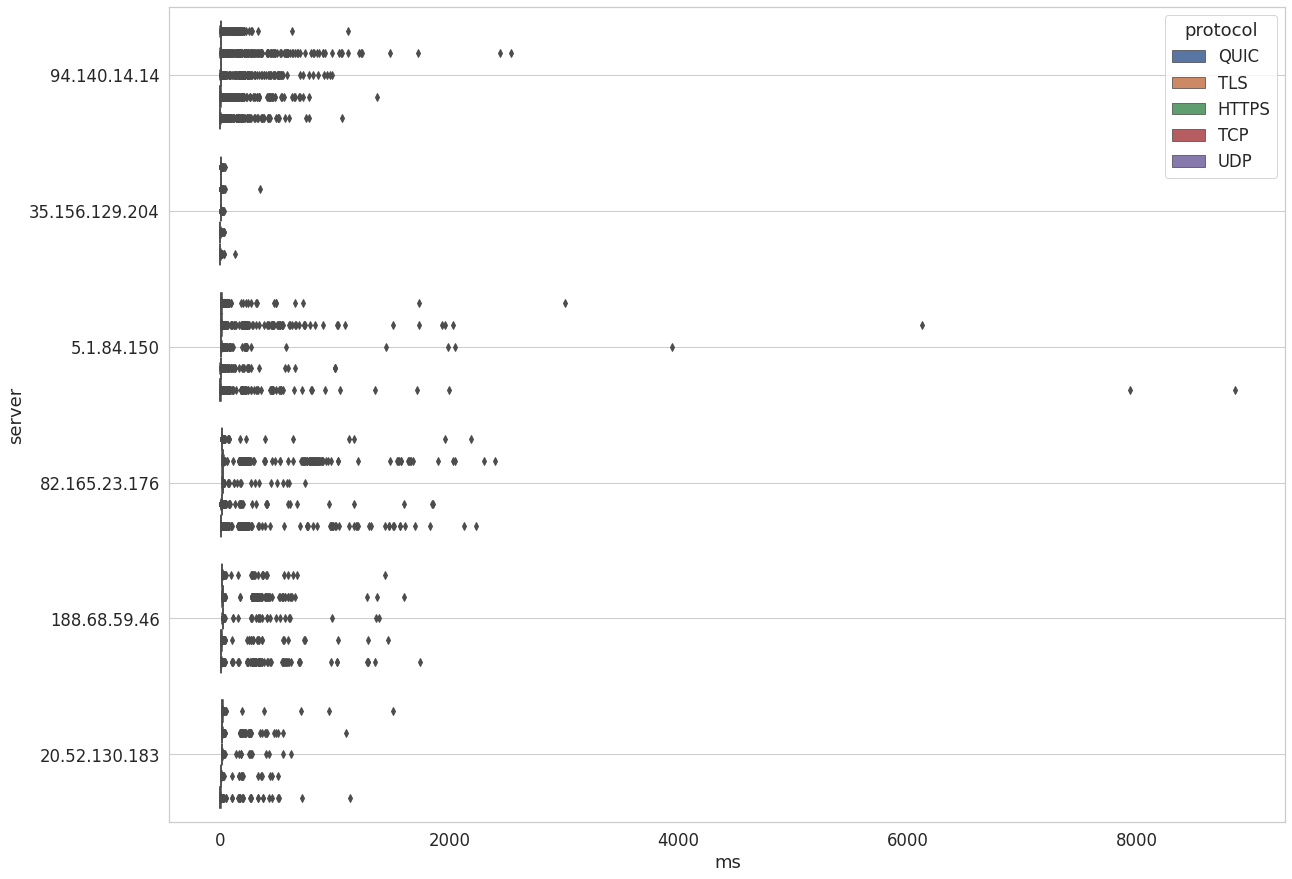

**Asia Pacific Southeast**

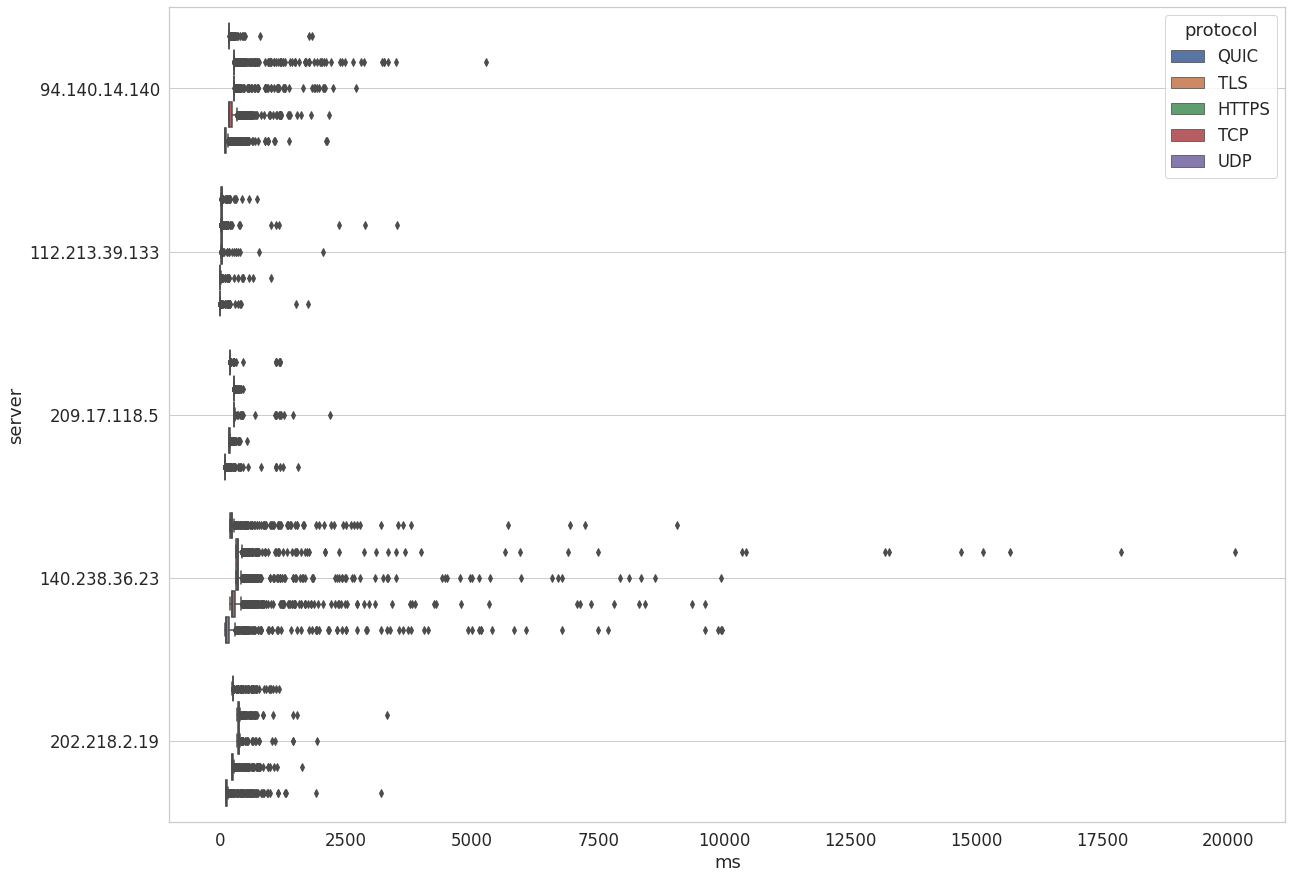

**US West**

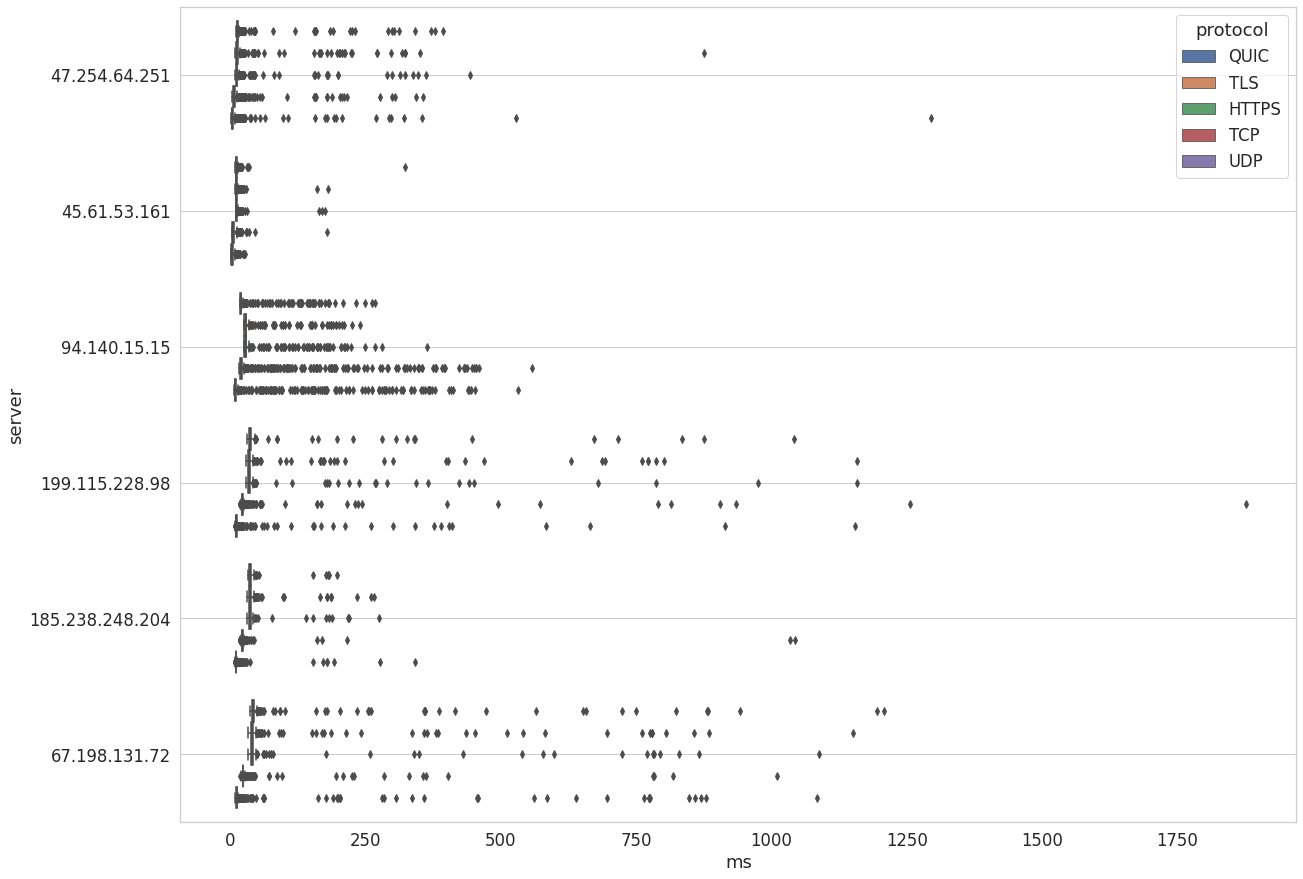

**South America East**

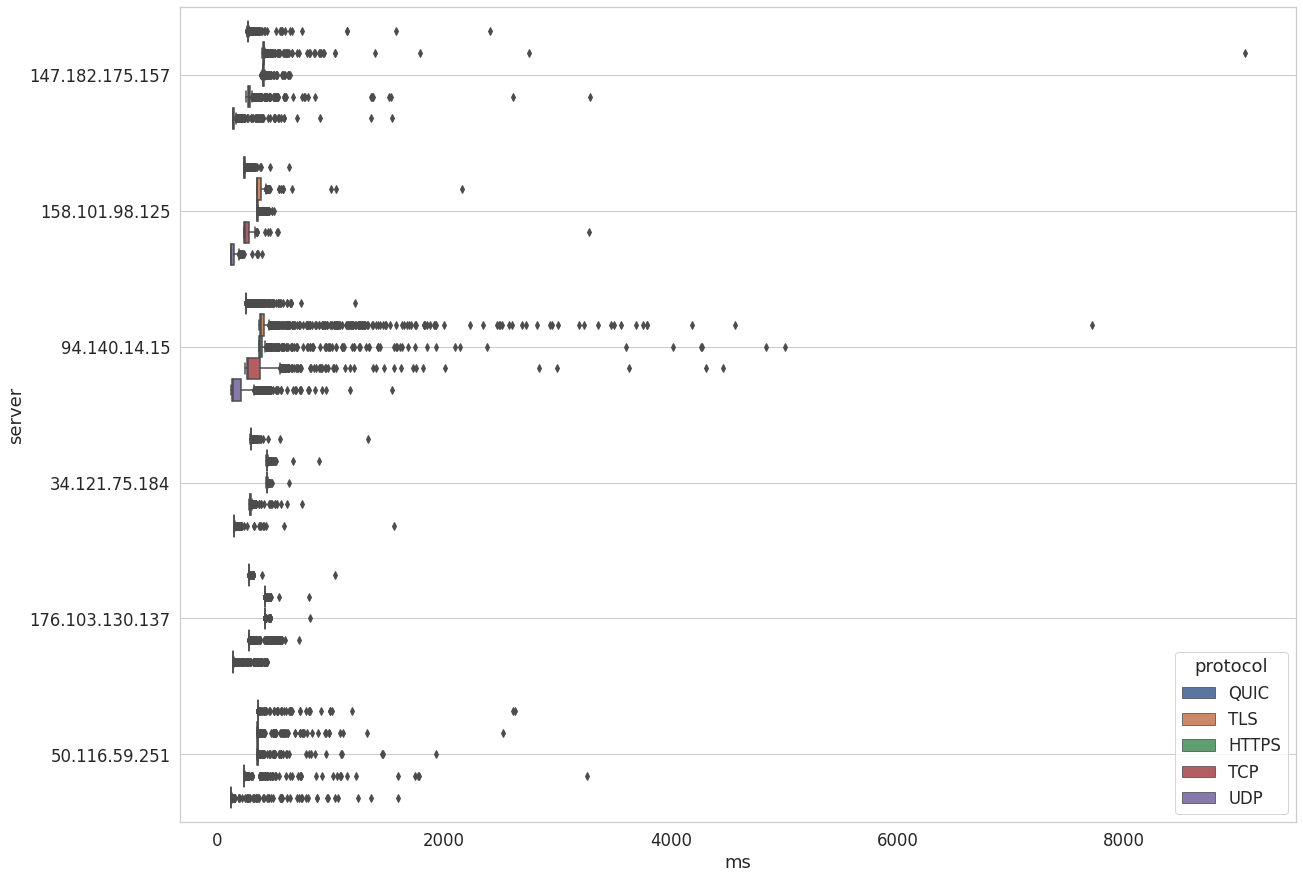

**All**

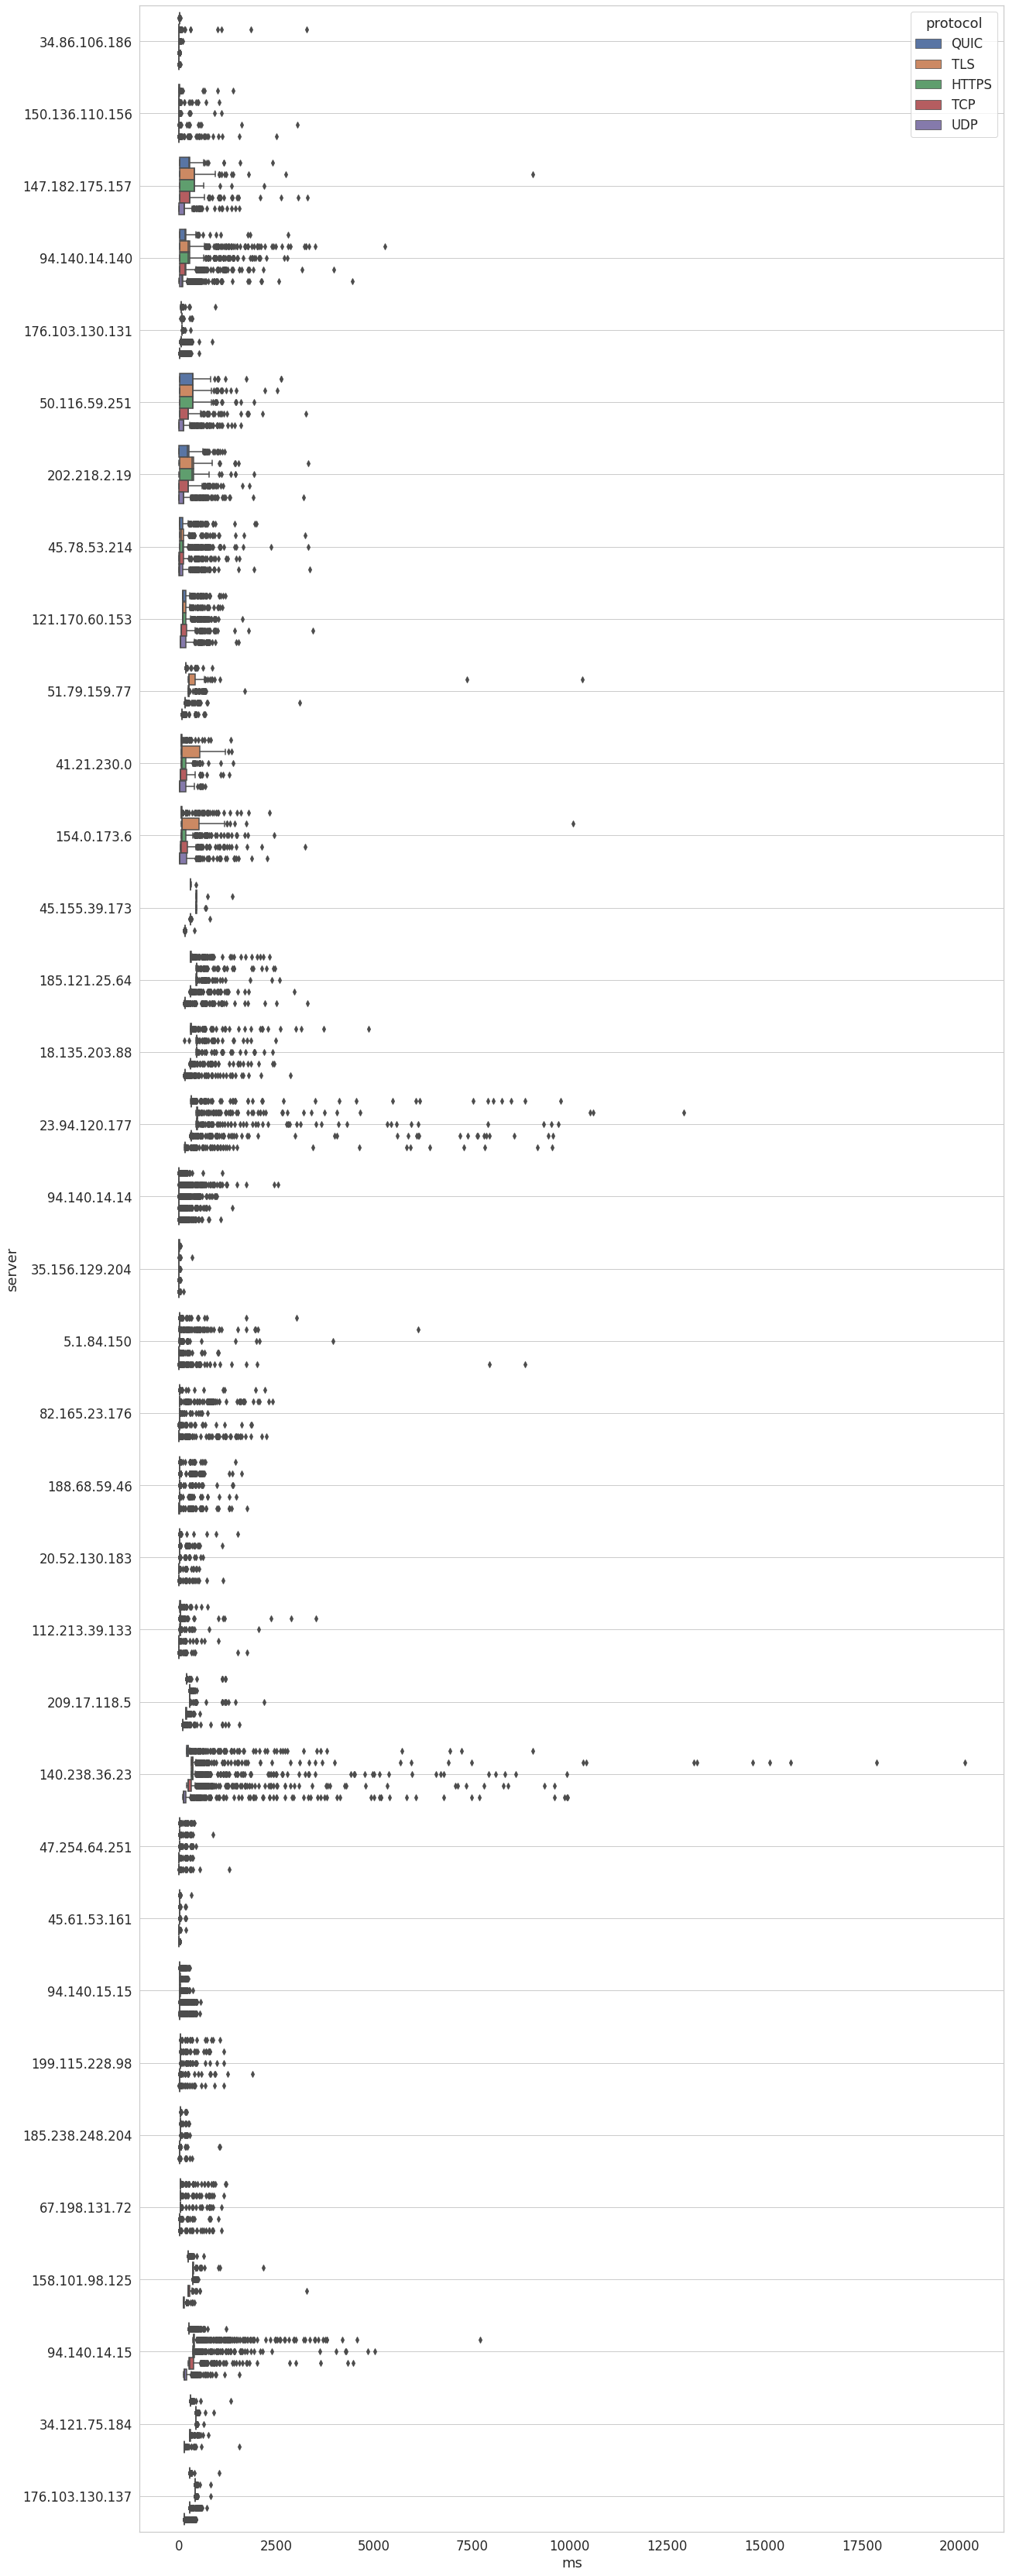

In [12]:
printmd(f"***Server Comparison (Lookup End)***")

plt.rcParams["figure.figsize"] = (20,15)
for vantagePoint in df['vantagePoint'].unique():
    singleCompareServers(vantagePoint)
plt.rcParams["figure.figsize"] = (20,60)
singleCompareServers()

***Server Comparison (Lookup End)***

**US East**

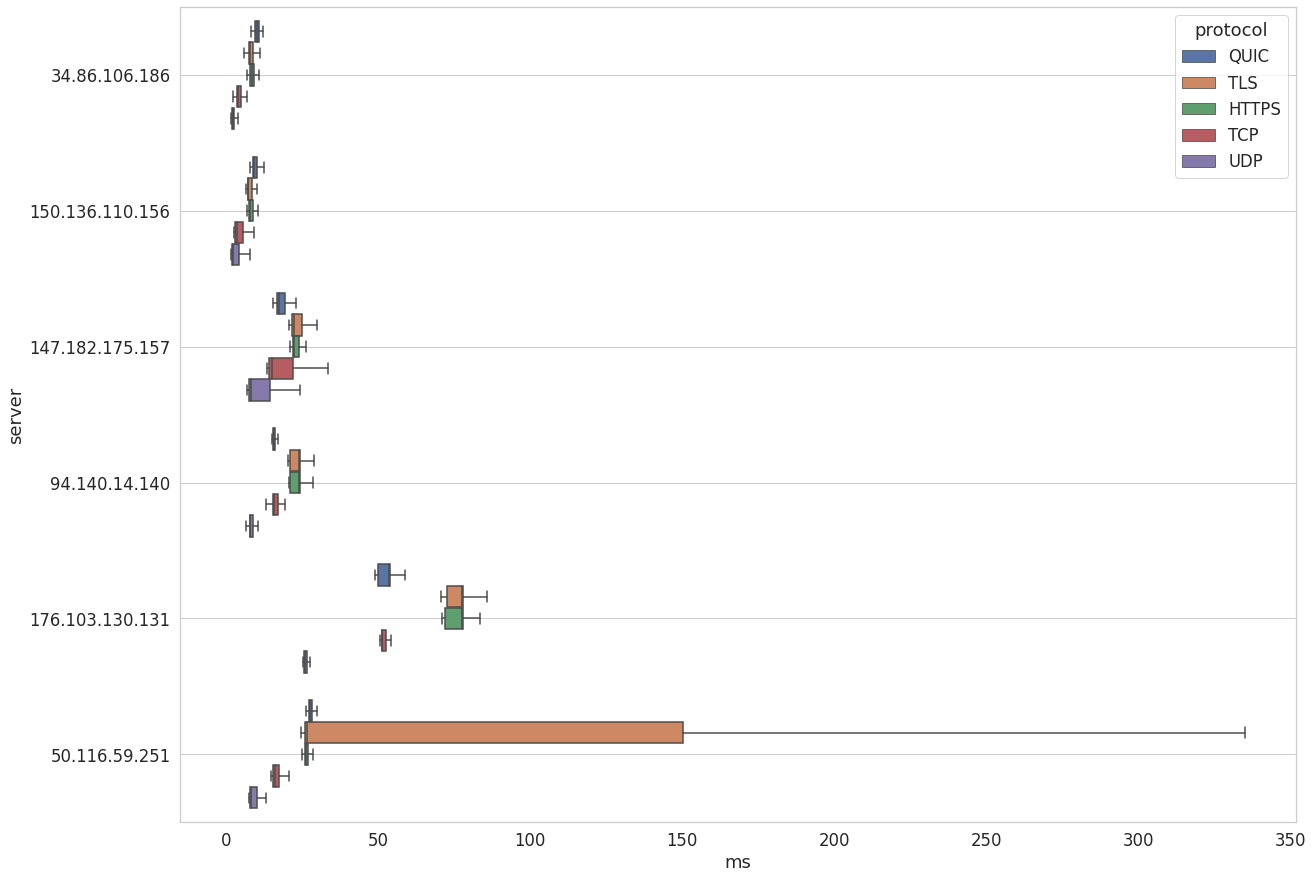

**Asia Pacific Northeast**

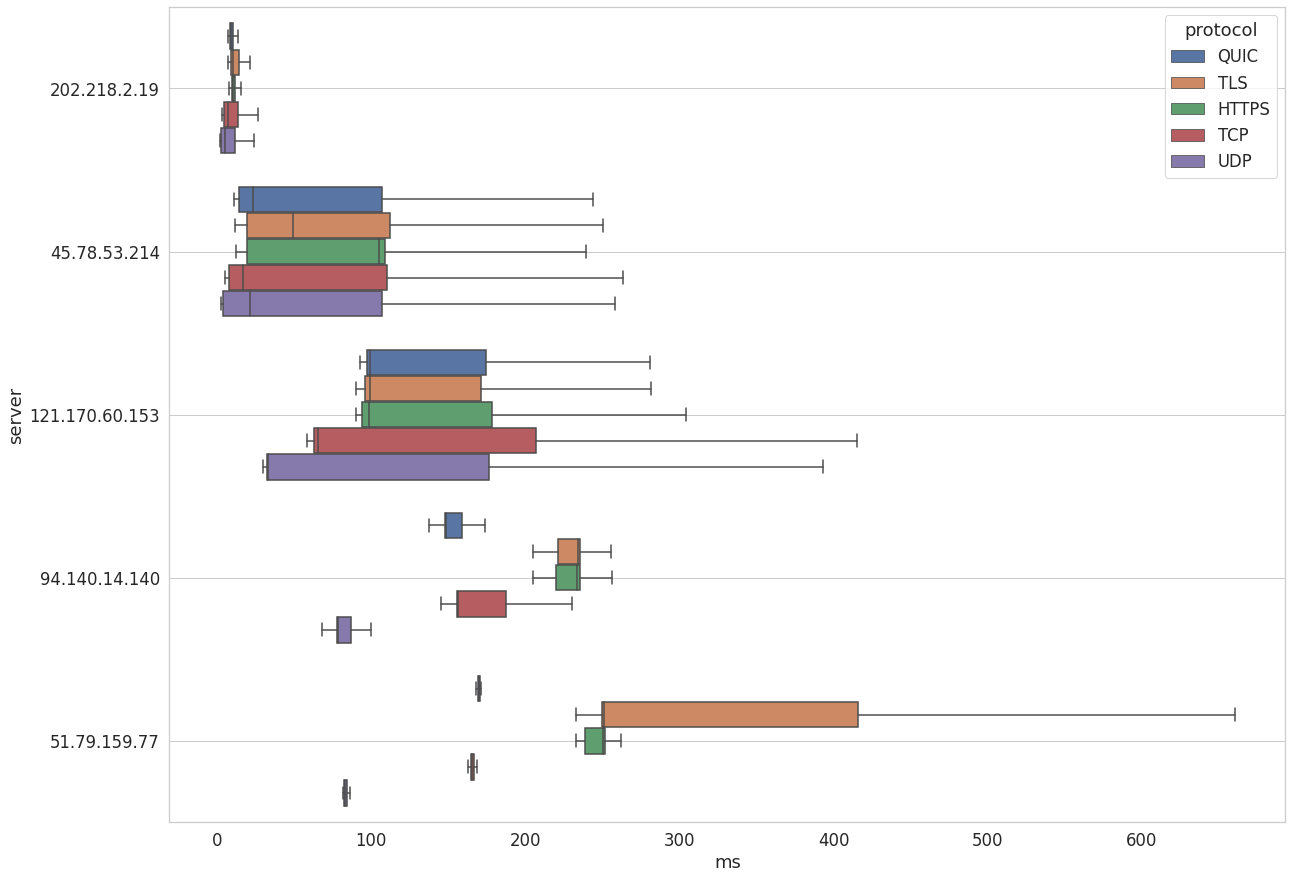

**Africa South**

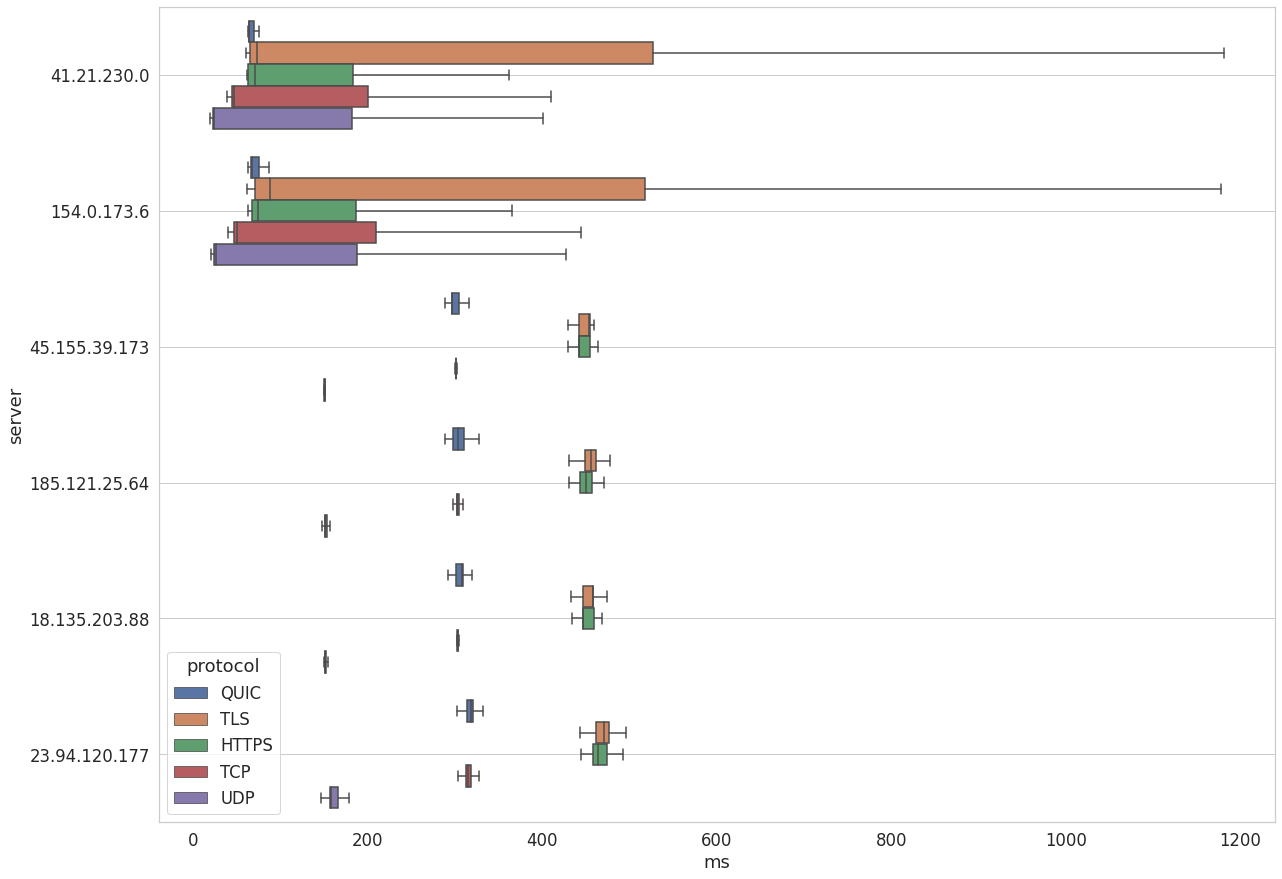

**Europe Central**

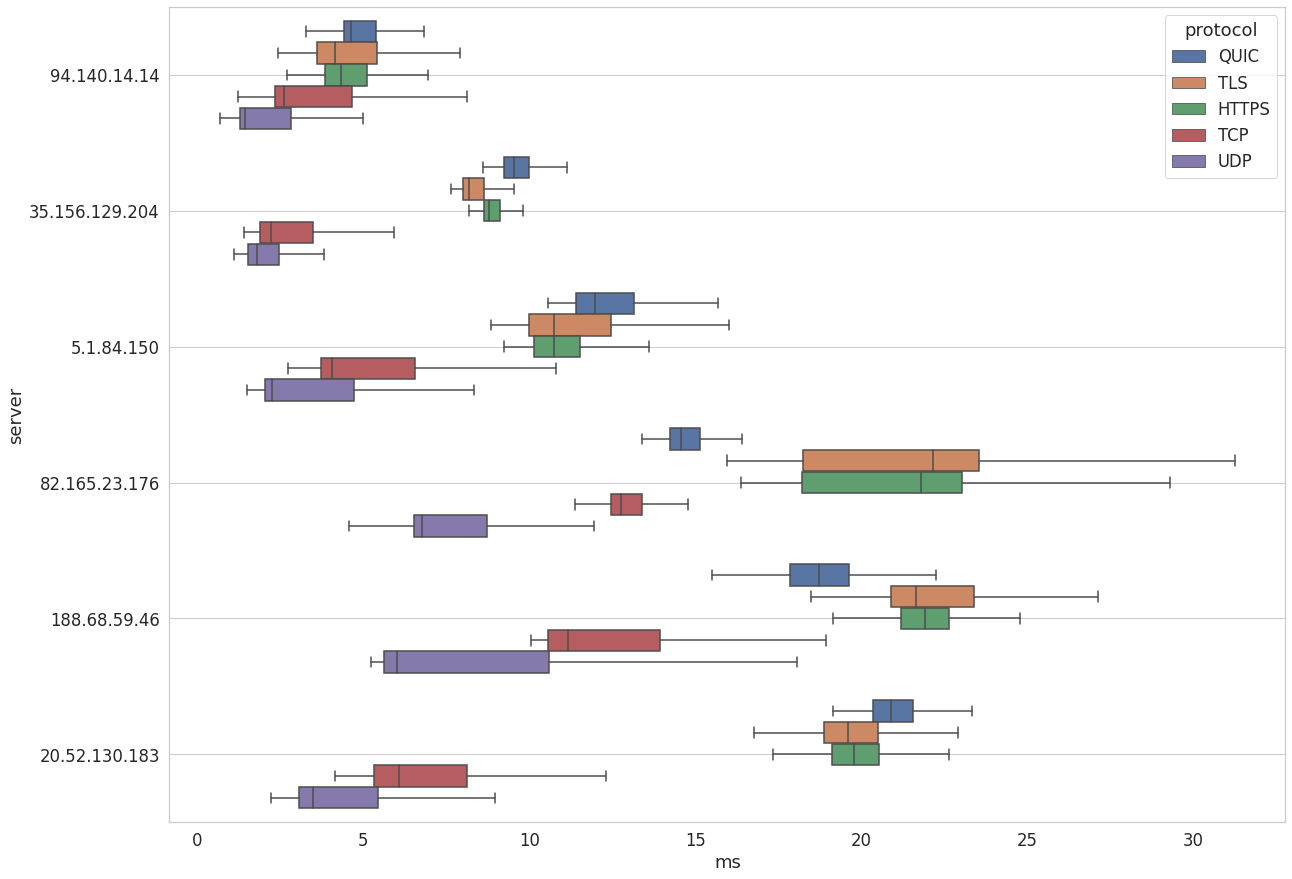

**Asia Pacific Southeast**

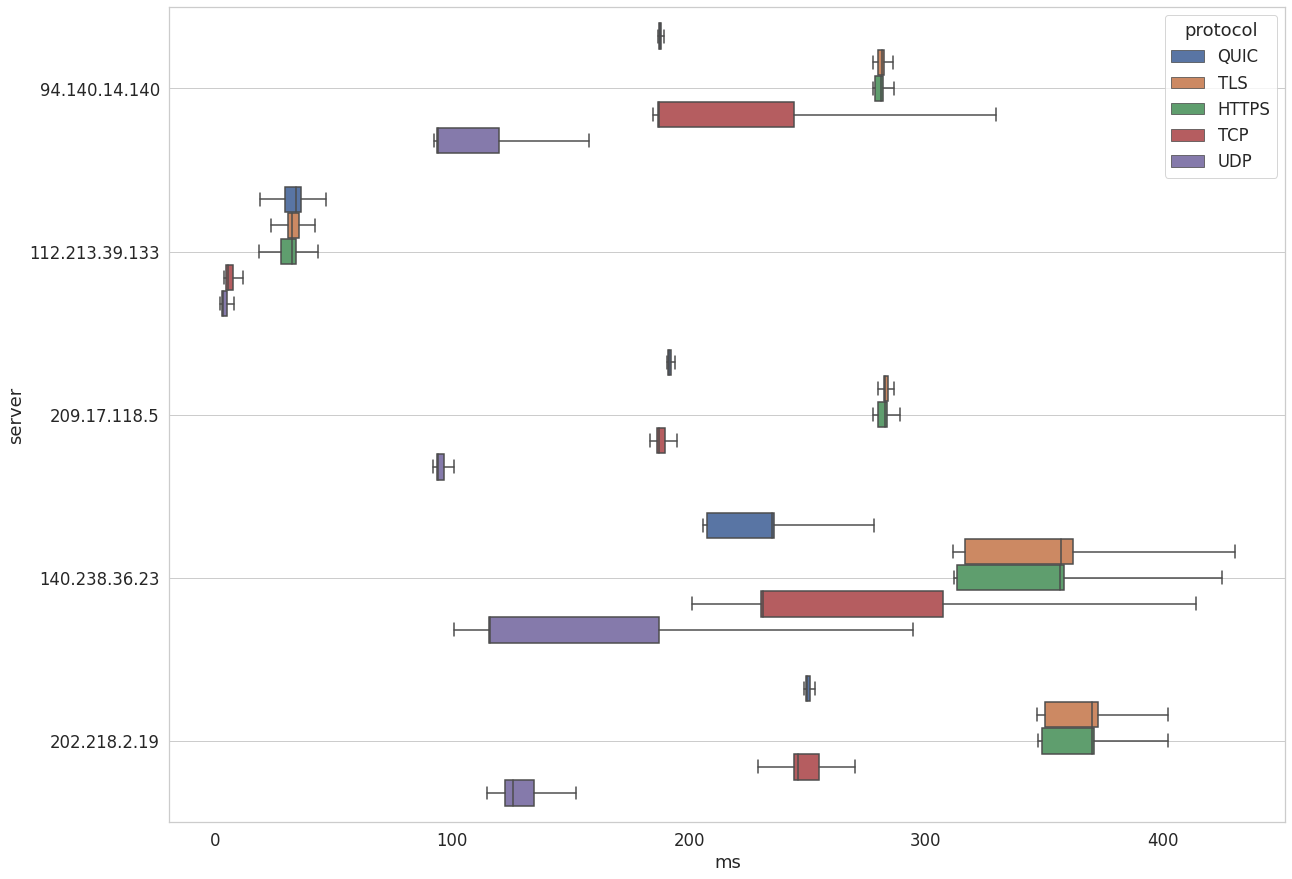

**US West**

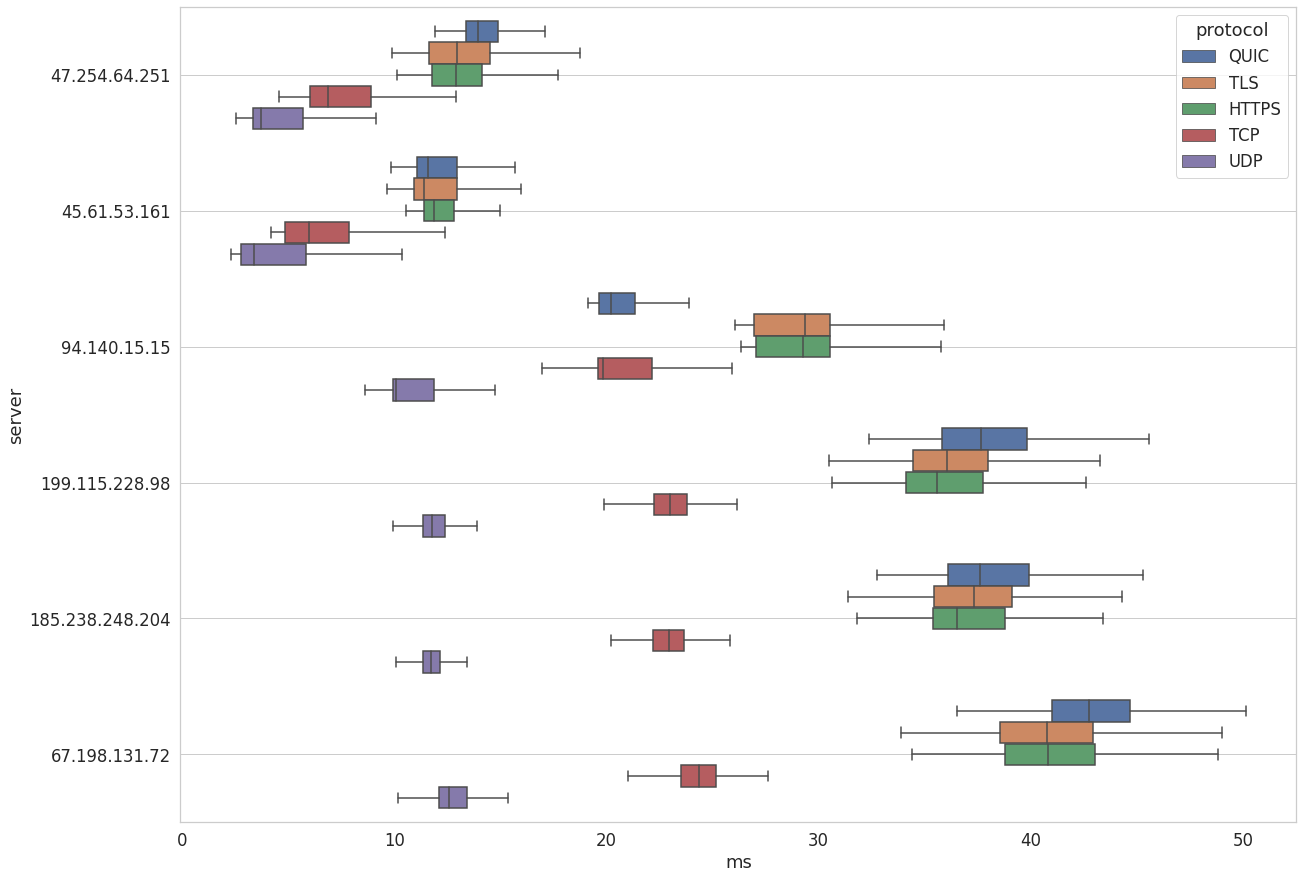

**South America East**

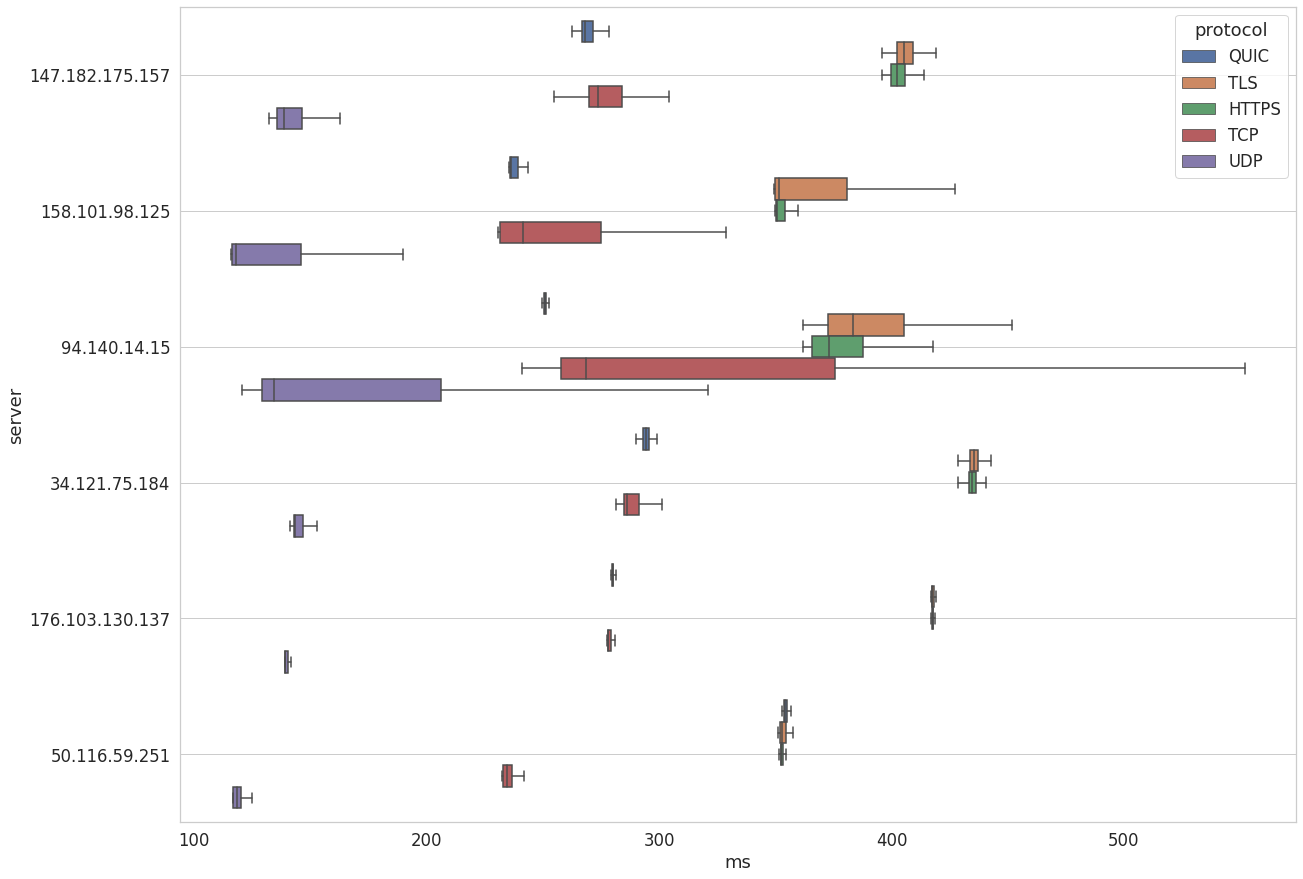

**All**

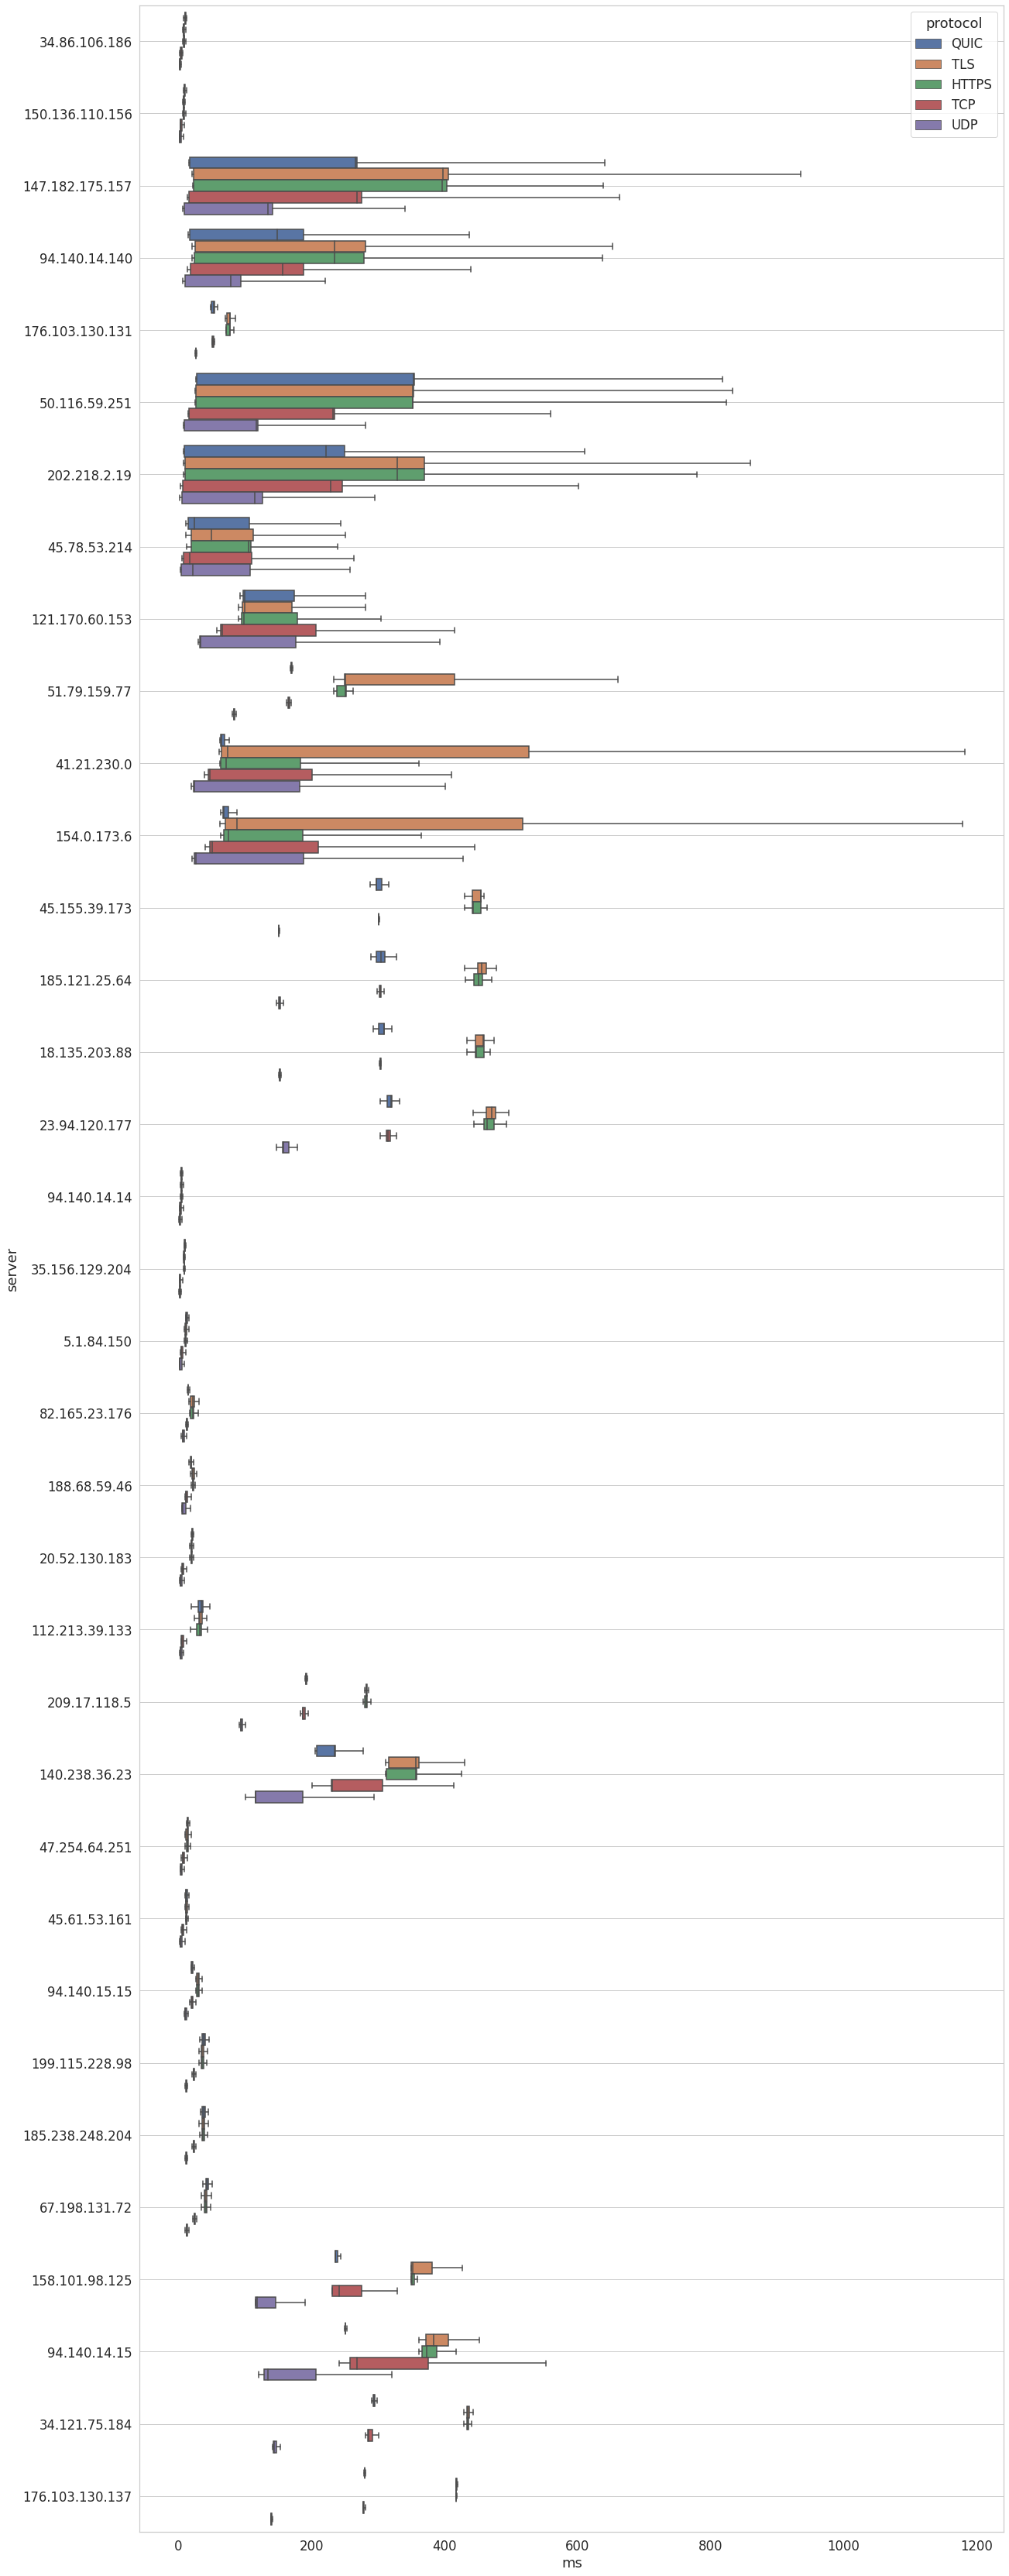

In [13]:
printmd(f"***Server Comparison (Lookup End)***")

plt.rcParams["figure.figsize"] = (20,15)
for vantagePoint in df['vantagePoint'].unique():
    singleCompareServers(vantagePoint, showfliers=False)
plt.rcParams["figure.figsize"] = (20,60)
singleCompareServers(showfliers=False)

In [14]:
def singleCompareVantagepoints(value_var='max_lookup_end', showfliers=False):
    plt.rcParams["figure.figsize"] = (20,30)
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    df_vp = df    
    df_melted = pd.melt(df_vp, id_vars=['protocol', 'vantagePoint'], value_vars=value_var)
    ax = sns.boxplot(x='value', y='vantagePoint', hue='protocol', hue_order=protocols, data=df_melted[df_melted['variable'] == value_var], orient='h', showfliers=showfliers)
    ax.set_ylabel('vantage point')
    ax.set_xlabel('ms')
    ax.grid()
    plt.show()

***Vantage Point Comparison (Lookup End)***

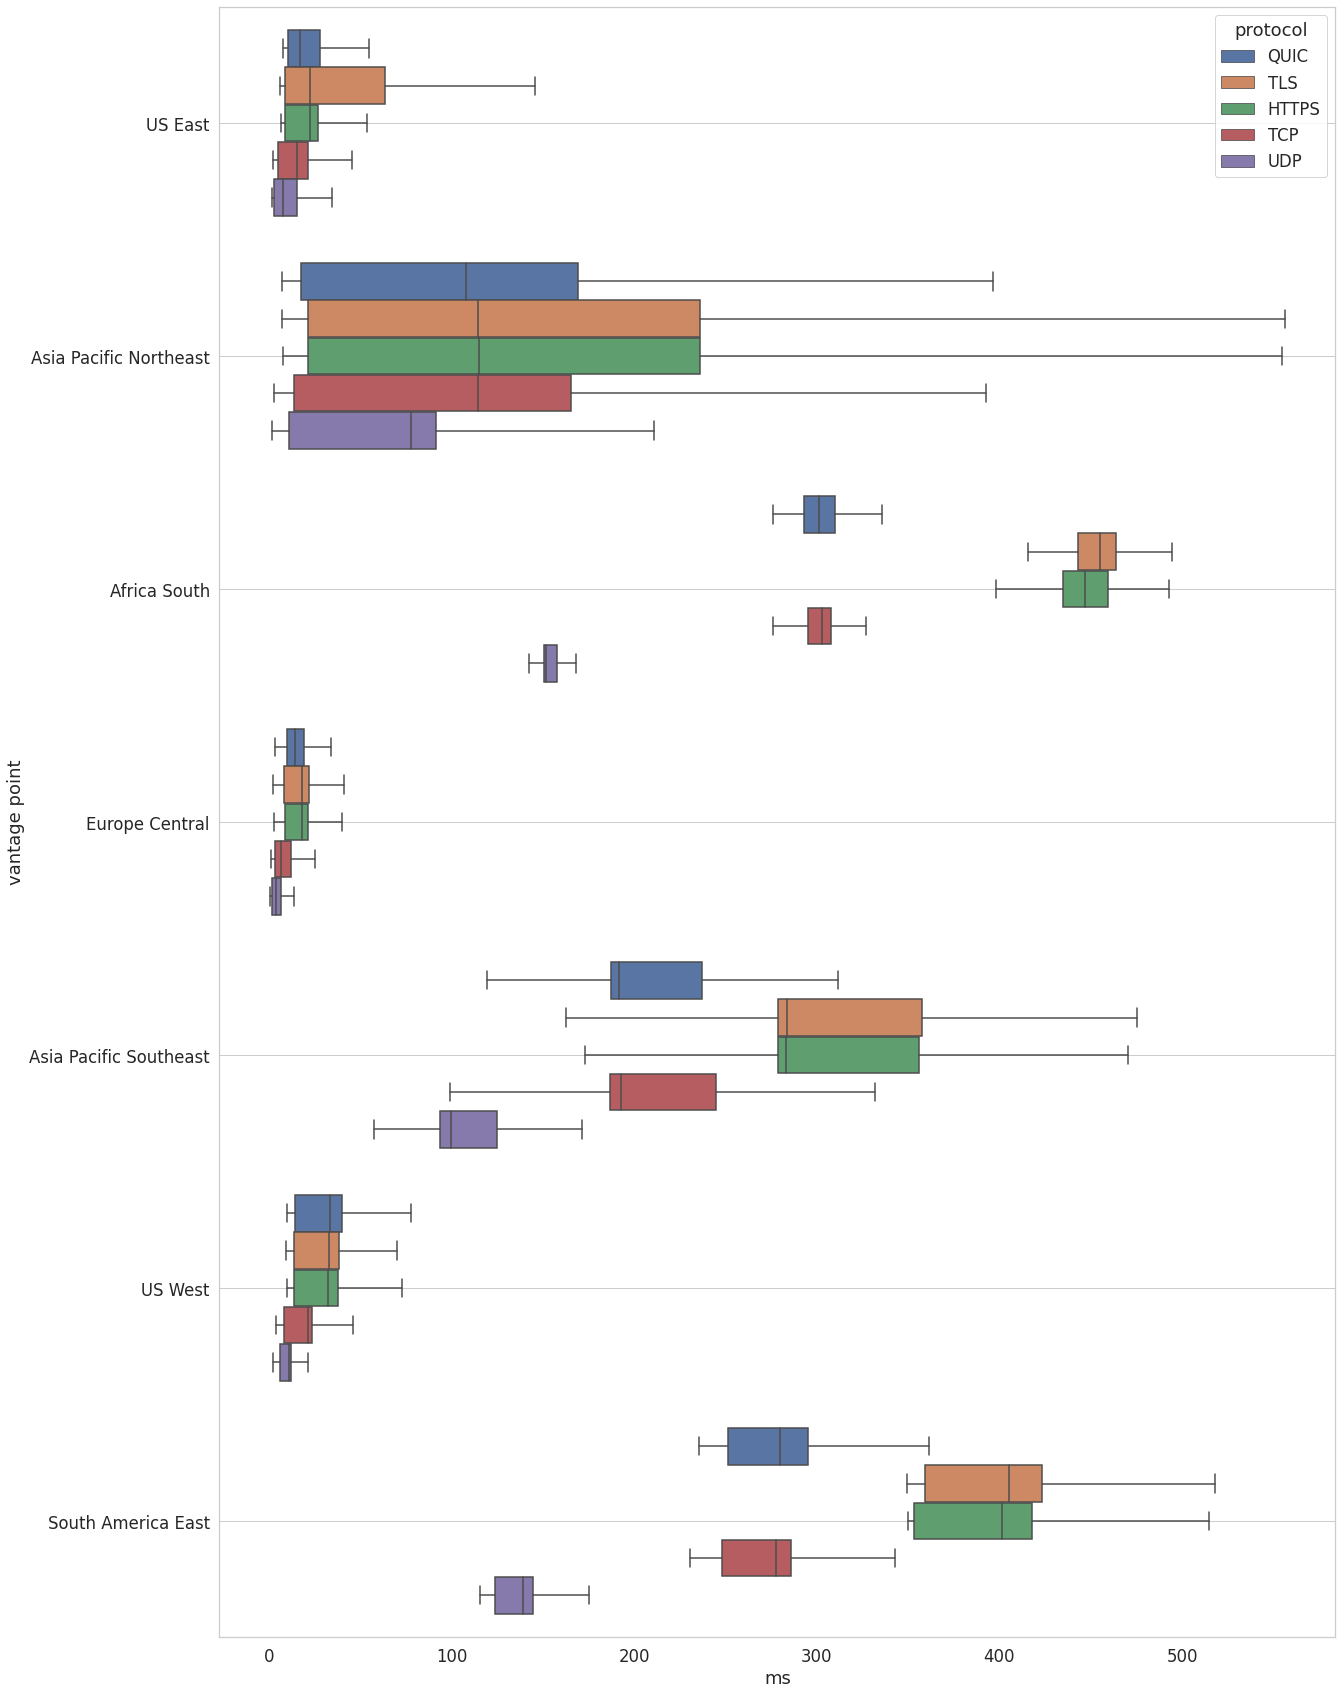

In [15]:
printmd(f"***Vantage Point Comparison (Lookup End)***")

singleCompareVantagepoints()

In [16]:
def compareQueries(domain):
    plt.rcParams["figure.figsize"] = (15,5)
    df_domain = df[df['domain'] == domain]
    
    printmd(f"**{domain}**")

    for vantagePoint in df['vantagePoint'].unique():
        df_vp = df_domain[df_domain['vantagePoint'] == vantagePoint]
        df_vp['queries'].hist(alpha=0.5, bins=30, label=vantagePoint)
    plt.legend()
    plt.show()

***Number of Queries for each Domain***

**google.com**

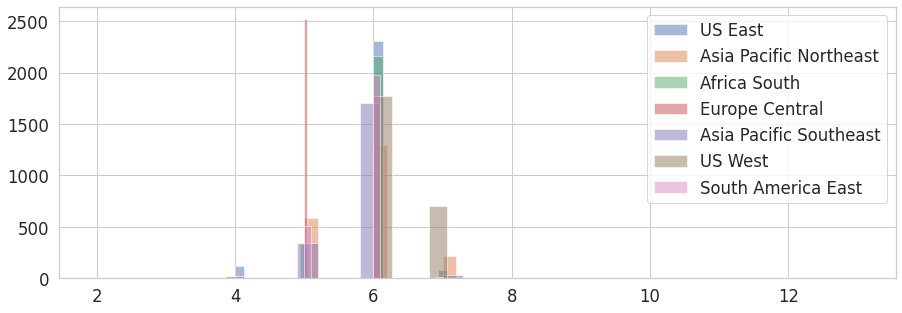

**youtube.com**

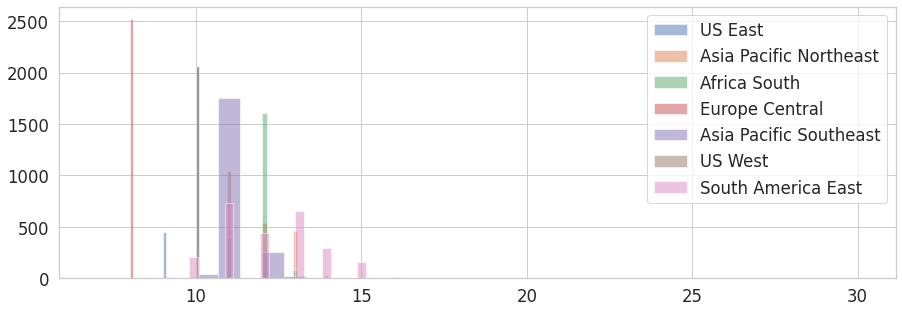

**facebook.com**

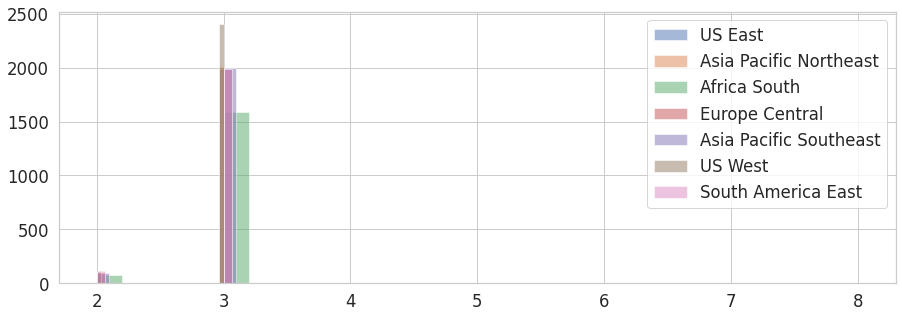

**netflix.com**

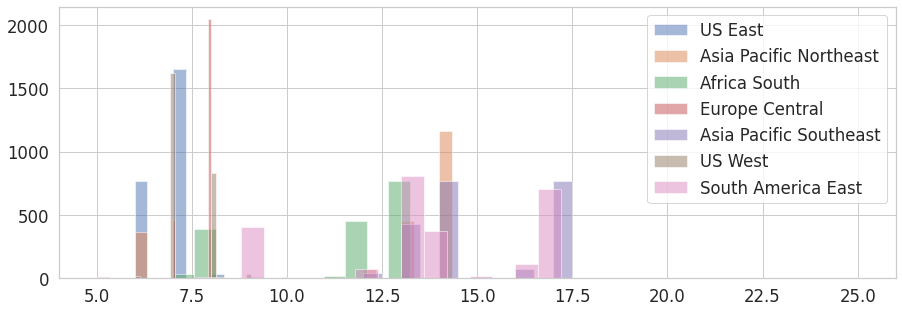

**microsoft.com**

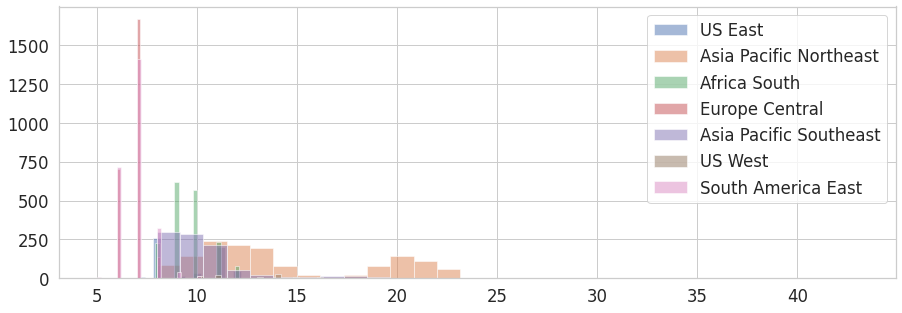

**twitter.com**

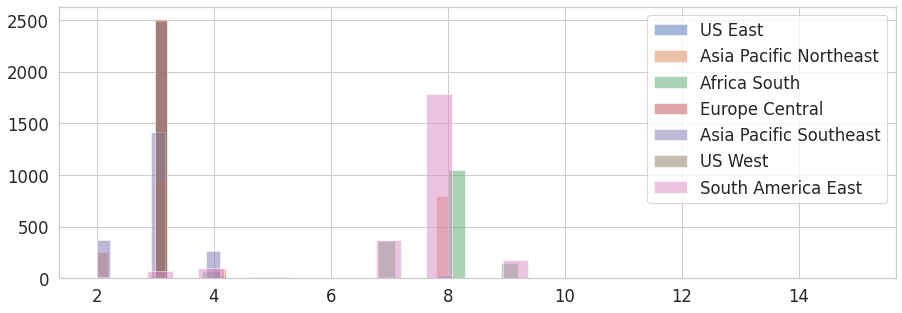

**instagram.com**

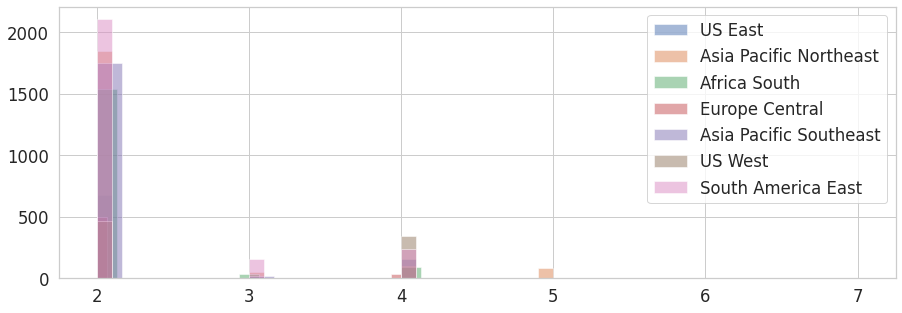

**tmall.com**

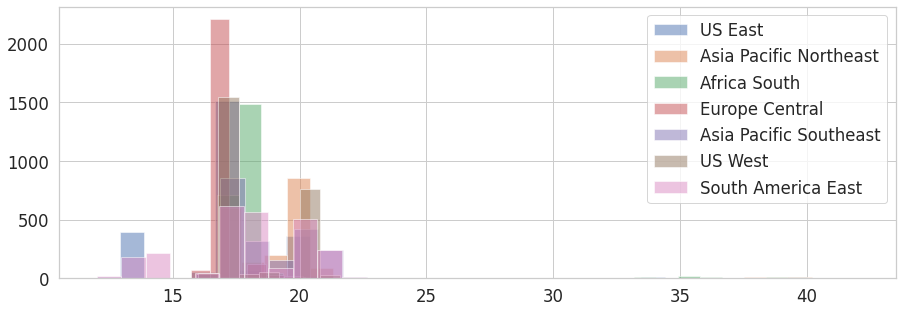

**linkedin.com**

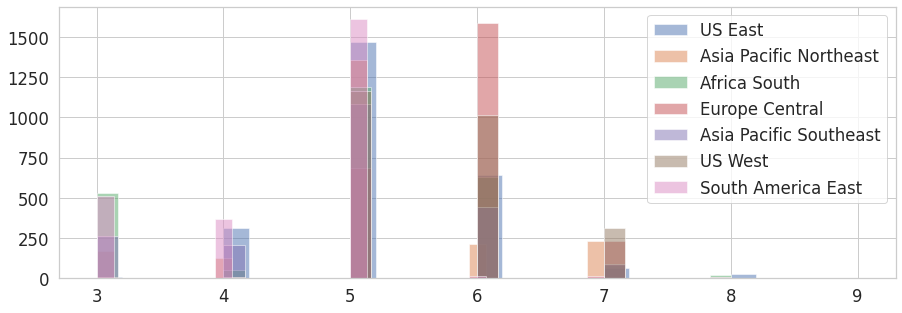

**apple.com**

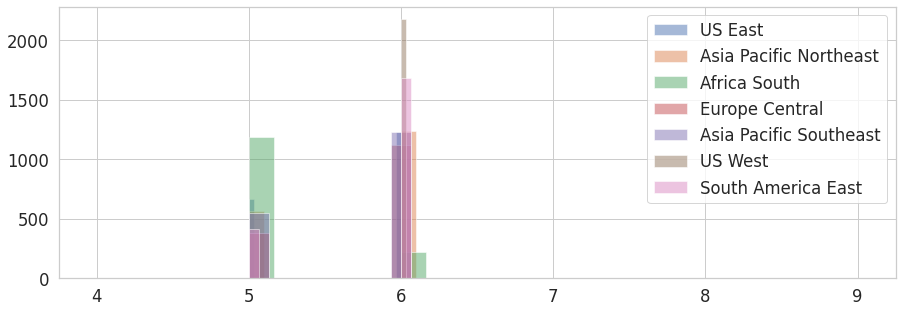

**wikipedia.org**

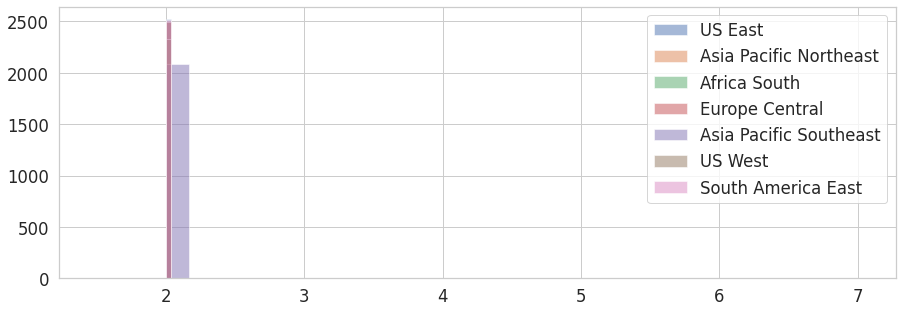

**baidu.com**

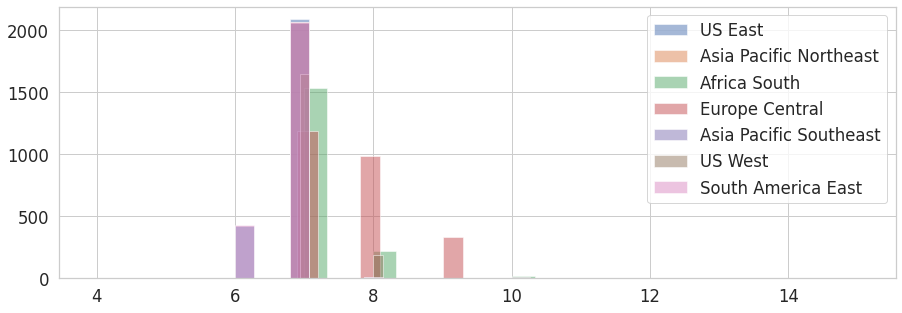

In [17]:
printmd(f"***Number of Queries for each Domain***")

for domain in df['domain'].unique():
    compareQueries(domain)

In [18]:
def compareQueries2(domain):
    plt.rcParams["figure.figsize"] = (25,10)
    df_domain = df[df['domain'] == domain]
    
    printmd(f"**{domain}**")
    fig, axs = plt.subplots(2, 4, sharex=True)
    i = 0
    for vantagePoint in df_domain['vantagePoint'].unique():
        df_vp = df_domain[df_domain['vantagePoint'] == vantagePoint]
        df_vp['queries'].hist(bins=10, label=vantagePoint, ax=axs[int(i/4),i%4])
        axs[int(i/4),i%4].set_title(vantagePoint)
        i+=1
    df_domain['queries'].hist(bins=10, label='All', ax=axs[1,3])
    axs[1,3].set_title('All')
    plt.show()

**google.com**

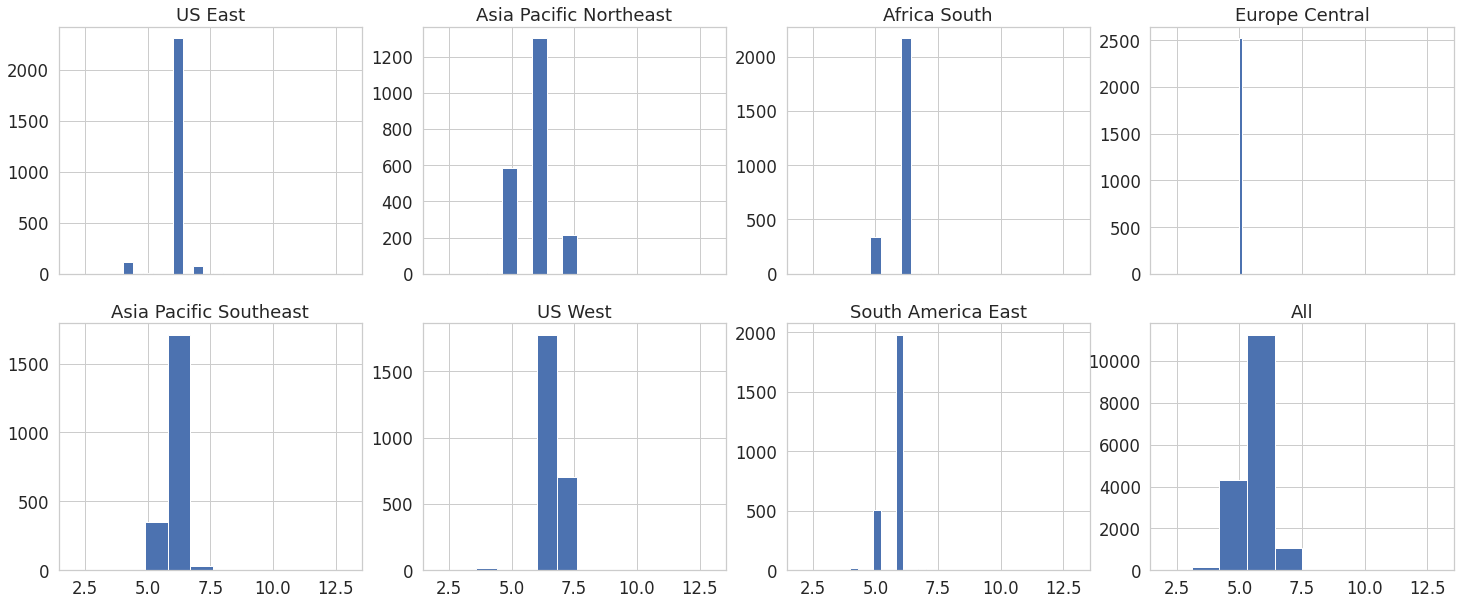

**youtube.com**

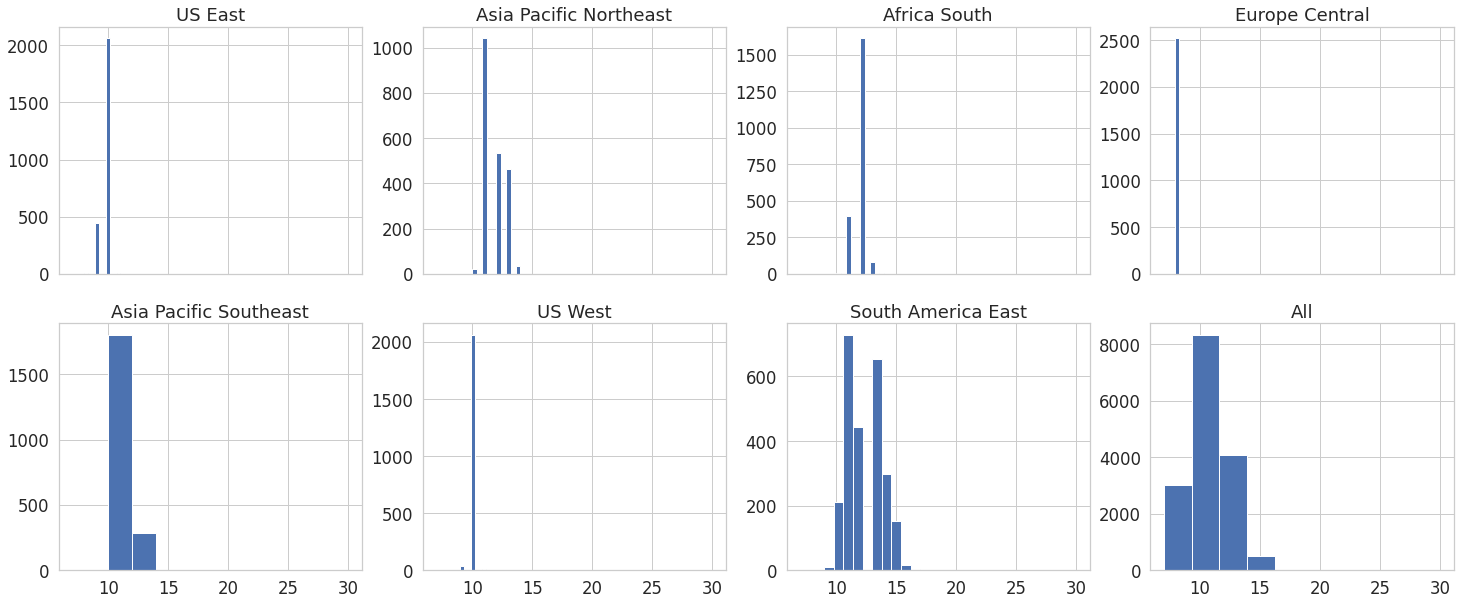

**facebook.com**

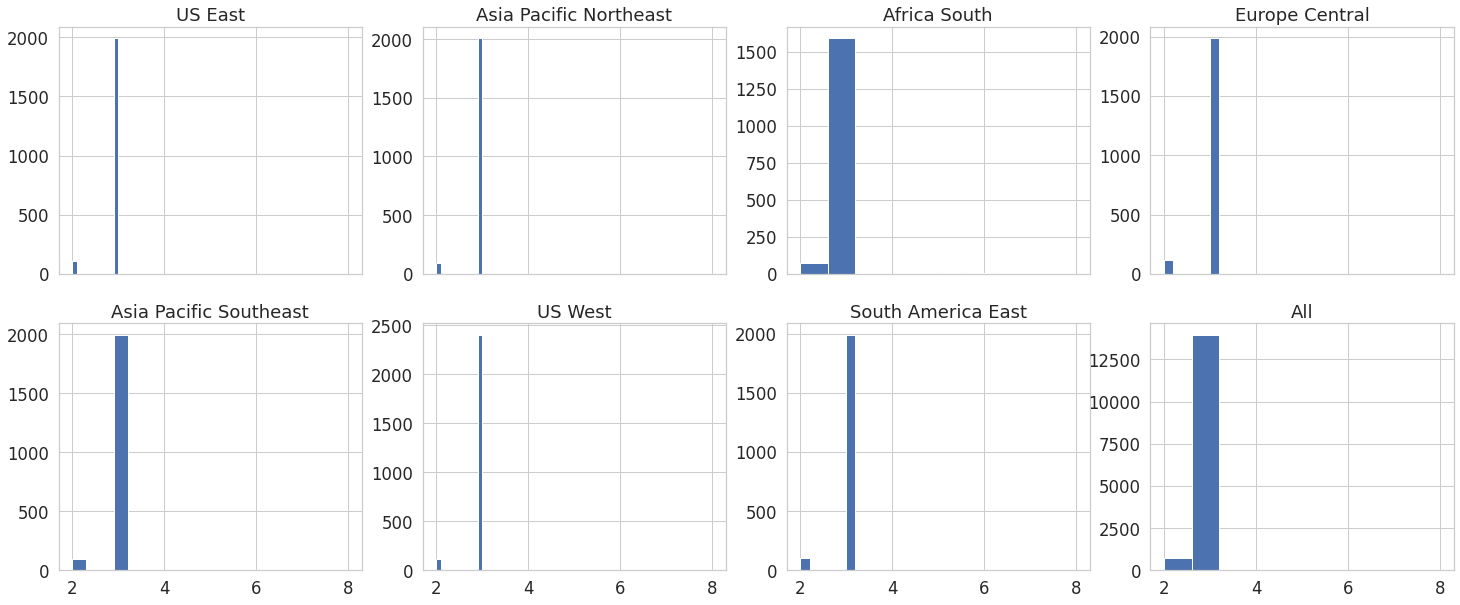

**netflix.com**

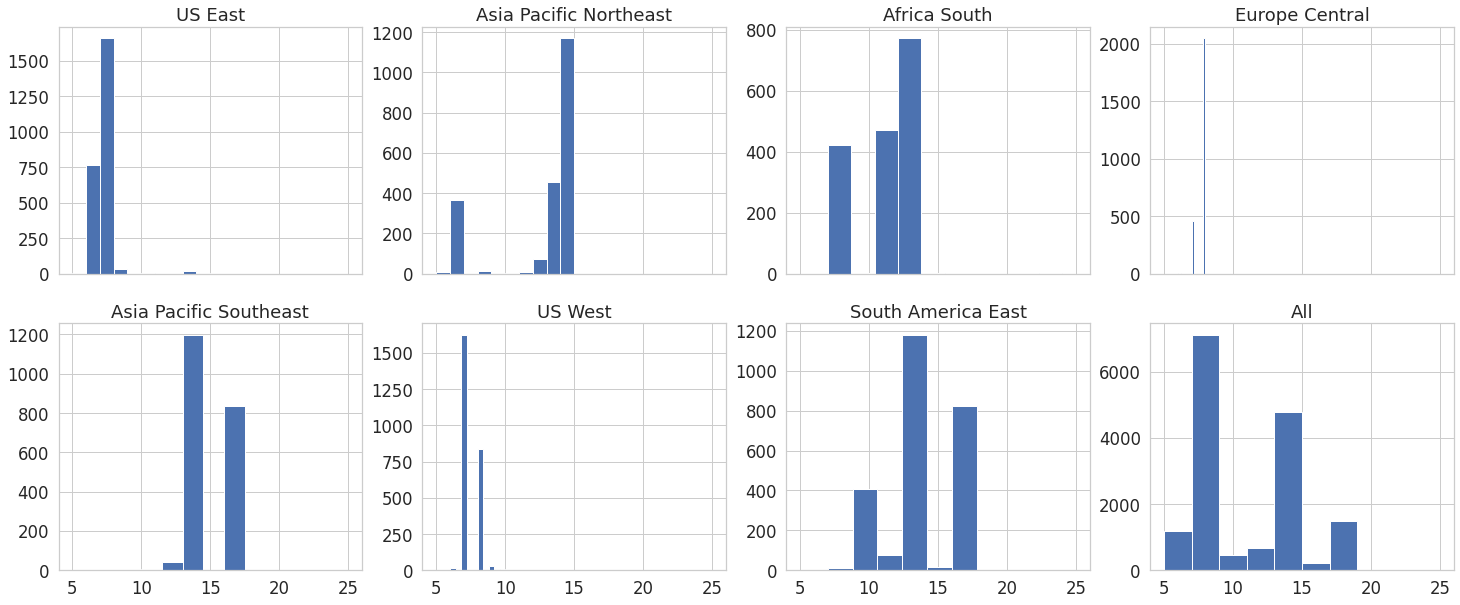

**microsoft.com**

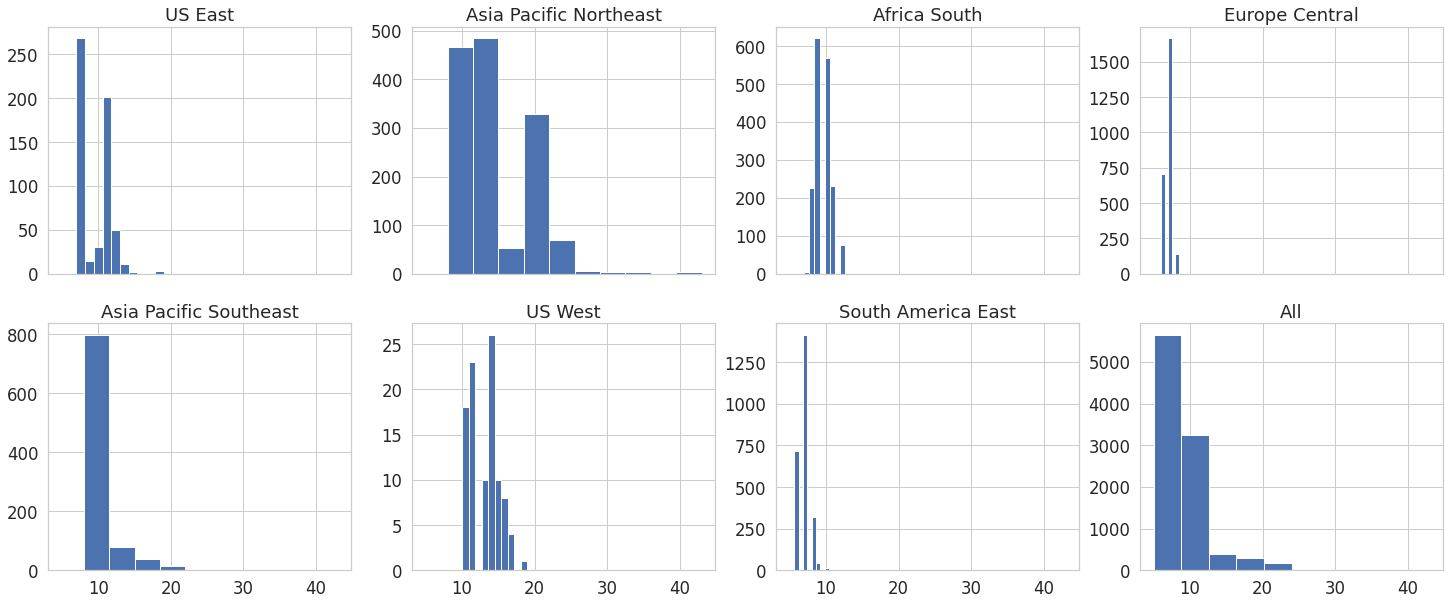

**twitter.com**

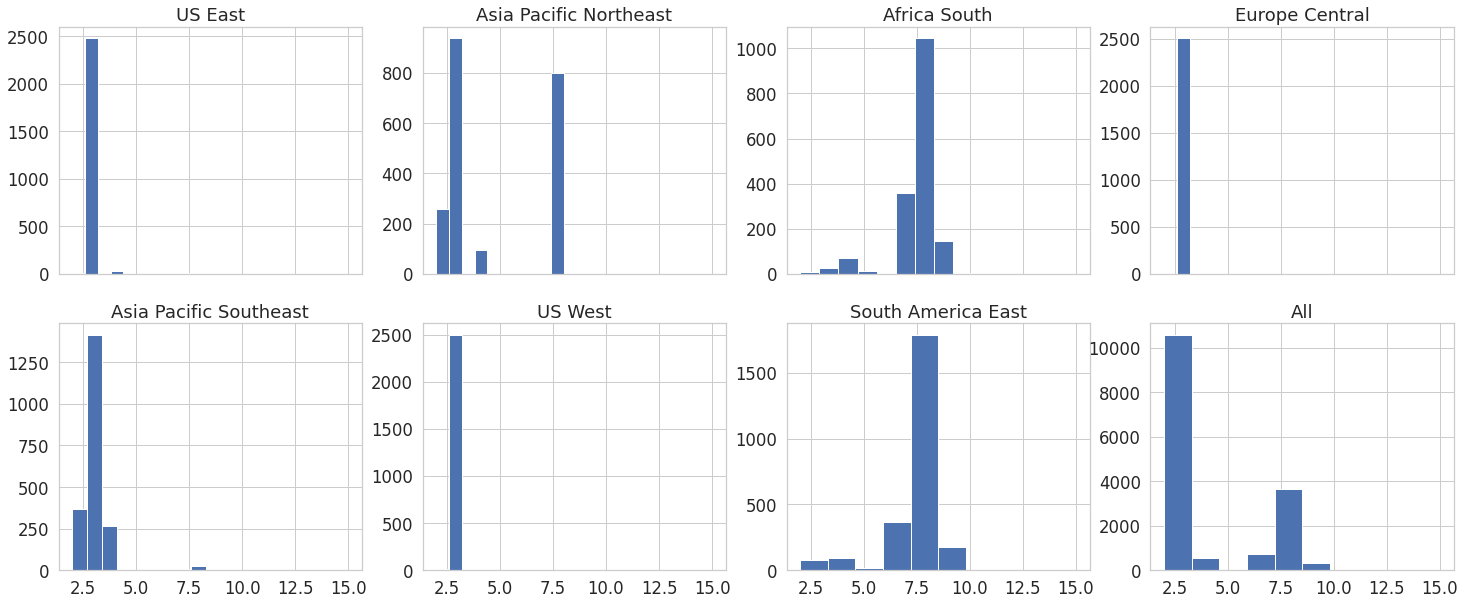

**instagram.com**

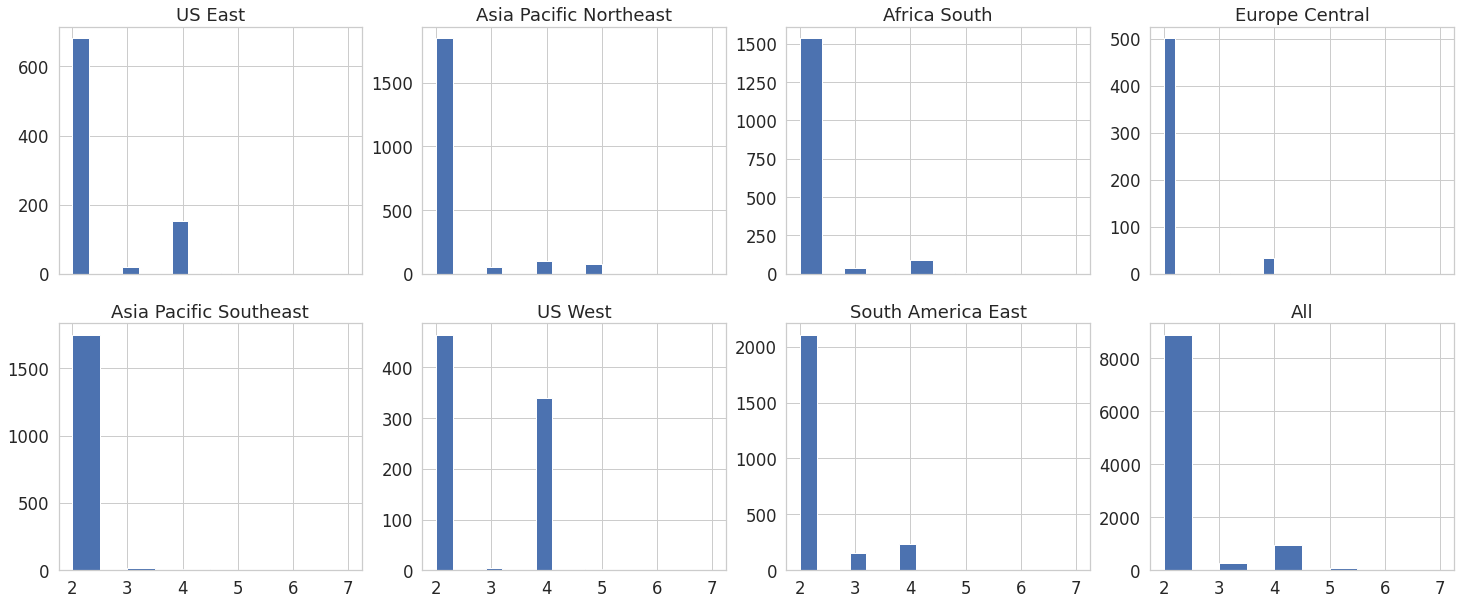

**tmall.com**

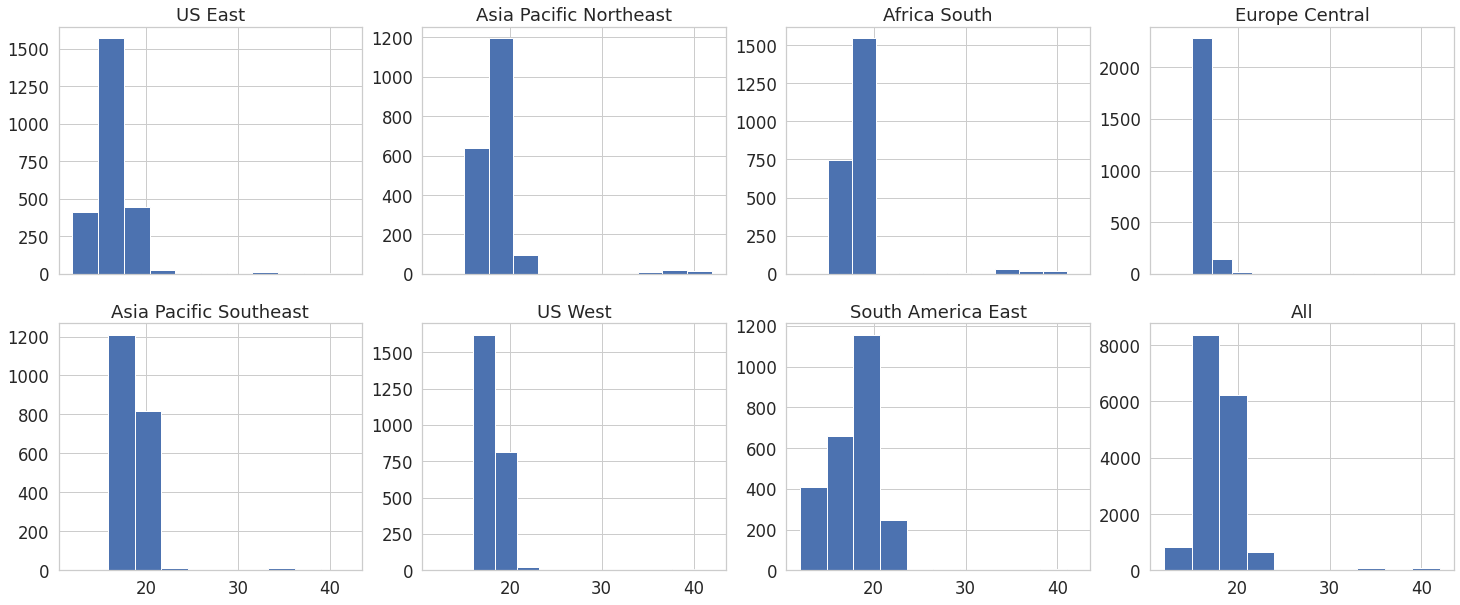

**linkedin.com**

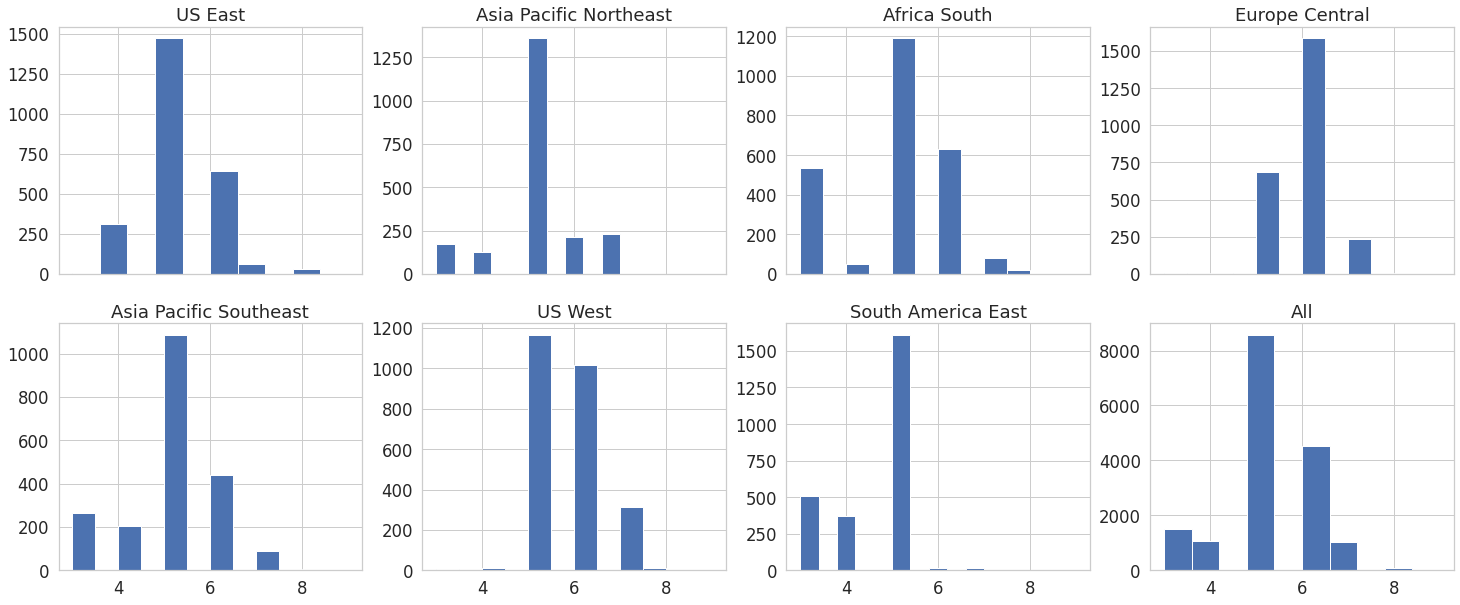

**apple.com**

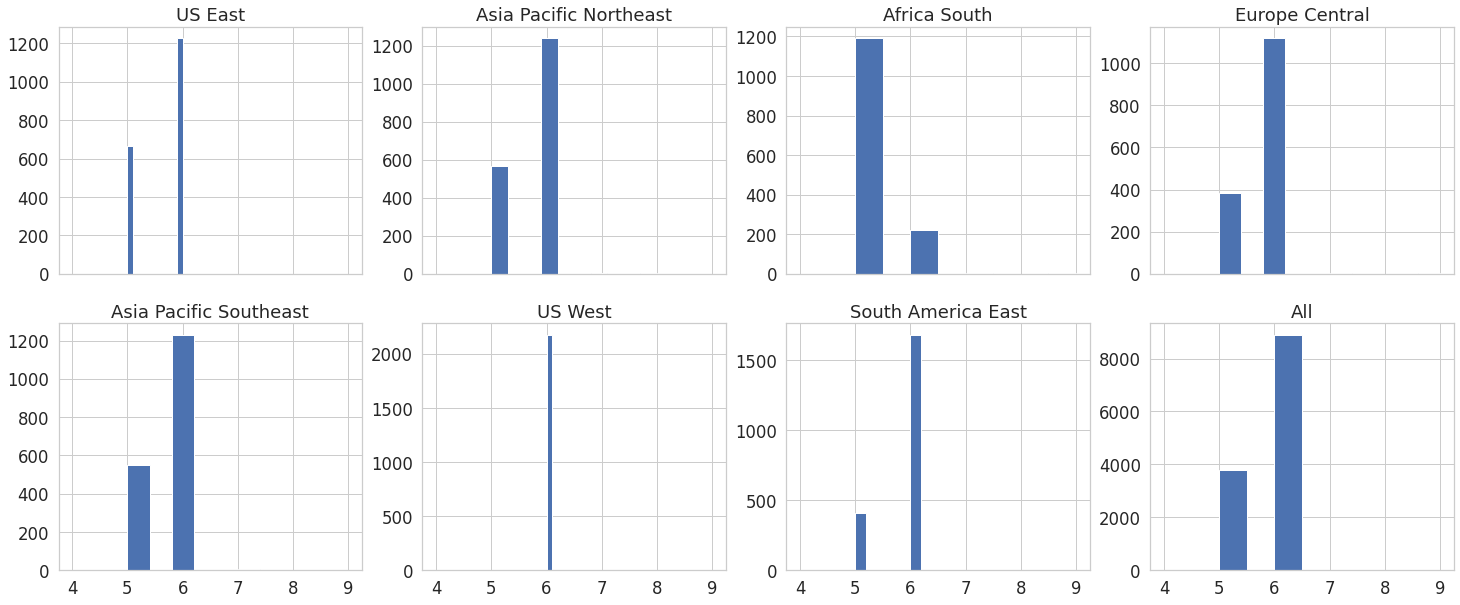

**wikipedia.org**

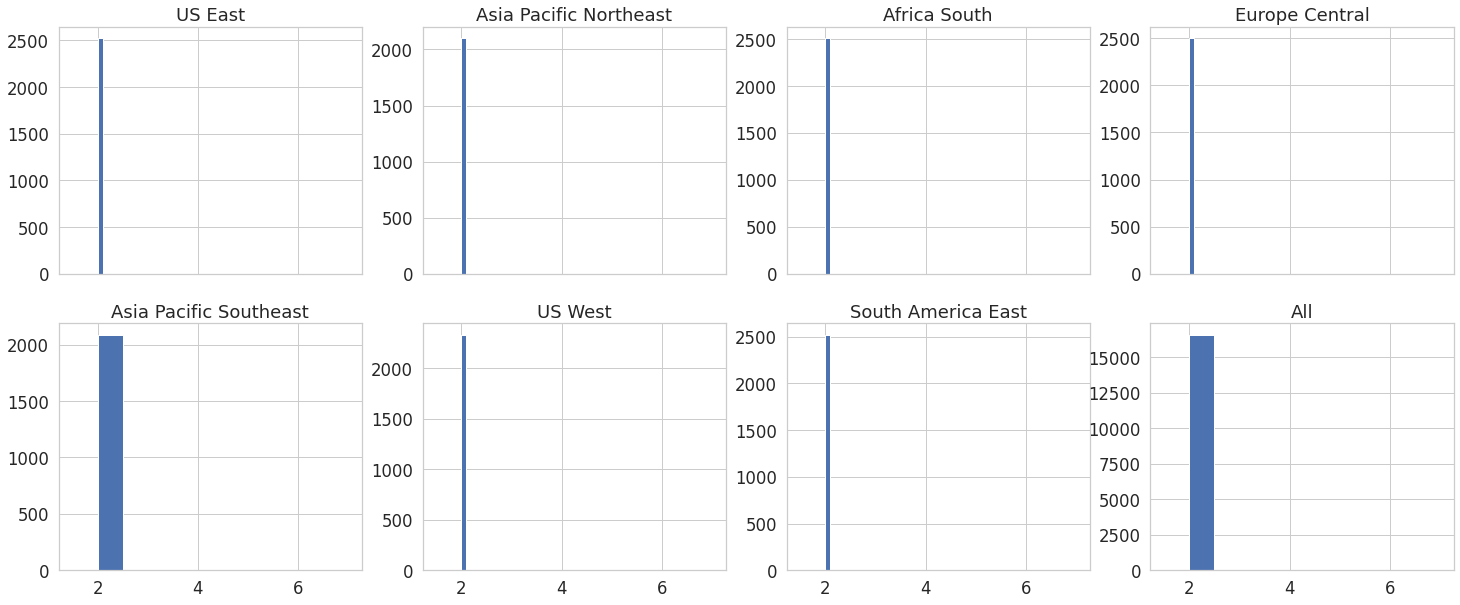

**baidu.com**

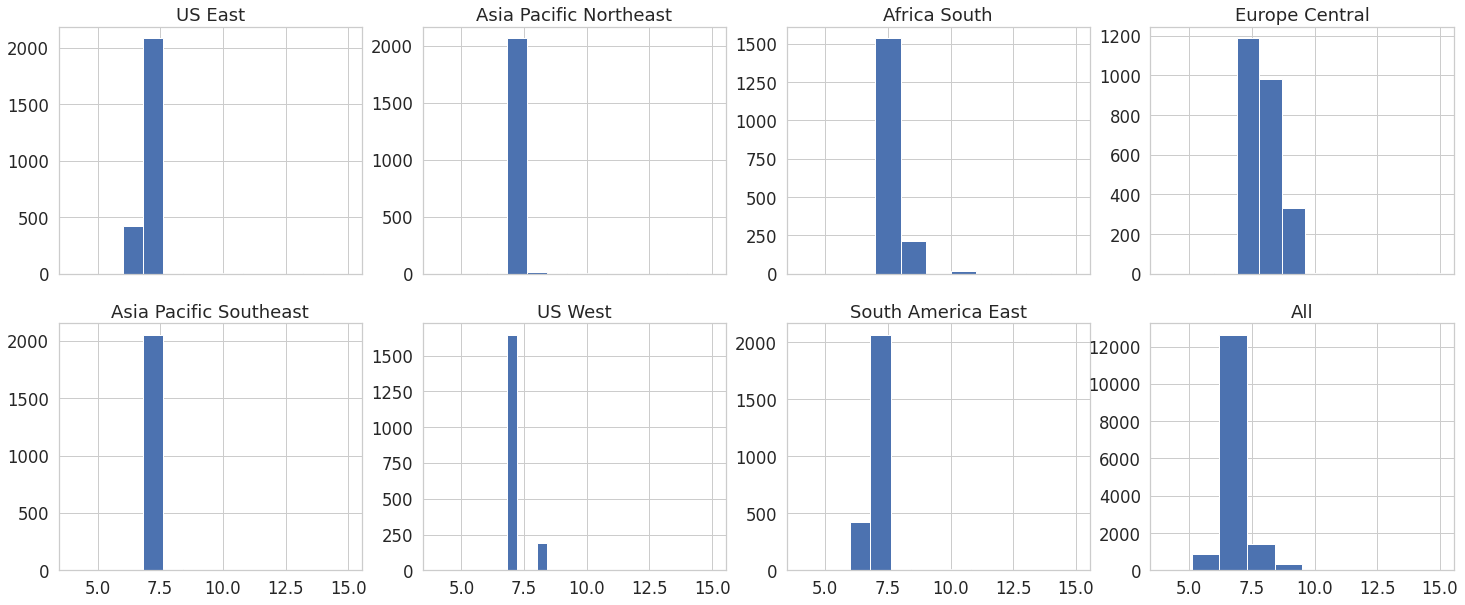

In [19]:
for domain in df['domain'].unique():
    compareQueries2(domain)